# Import modules

In [2]:
import sys
import os
import warnings
import os.path as op
from glob import glob

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm

sys.path.append(op.join(op.expanduser("~"), "code", "style"))
from colors import get_colors

co, palettes = get_colors()

from general.basic.config import get_plot_defaults, set_rcparams

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)

# Load and format data

## Setup

In [3]:
def glob_sort_mtime(pattern):
    """Return files matching pattern in most recent modified order.

    Returns
    -------
    files : list of str
        List of files matching pattern, sorted by most recent modified
        (files[0] is the most recently modified).
    """
    files = sorted(glob(pattern), key=op.getmtime, reverse=True)
    return files


def frglob(topdir, base_starts="", base_ends="", base_contains="", path_contains=""):
    """Return a list of all files nested under topdir that meet criteria

    A fast, recursive glob search.
    """

    def _path_recurse(
        path, base_starts="", base_ends="", base_contains="", path_contains=""
    ):
        with os.scandir(path) as entries:
            for entry in entries:
                if entry.is_dir():
                    _path_recurse(
                        entry.path, base_starts, base_ends, base_contains, path_contains
                    )
                elif entry.is_file():
                    if base_starts:
                        if not entry.name.startswith(base_starts):
                            continue
                    if base_ends:
                        if not entry.name.endswith(base_ends):
                            continue
                    if base_contains:
                        if base_contains not in entry.name:
                            continue
                    if path_contains:
                        if path_contains not in op.relpath(
                            op.dirname(entry.path), path
                        ):
                            continue
                    outfiles.append(entry.path)

    outfiles = []
    _path_recurse(topdir, base_starts, base_ends, base_contains, path_contains)
    return outfiles

In [4]:
# Define project paths
proj_dir = "/mnt/coredata/processing/leads"
code_dir = op.join(proj_dir, "code")
data_dir = op.join(proj_dir, "data")
metadata_dir = op.join(proj_dir, "metadata")

extraction_dir = op.join(data_dir, "extraction")
proc_dir = op.join(data_dir, "processed")

atri_dir = op.join(metadata_dir, "atri")
loni_dir = op.join(metadata_dir, "loni")
scans_to_process_dir = op.join(metadata_dir, "scans_to_process")
qc_dir = op.join(metadata_dir, "qc")

qreport_dir = op.join(extraction_dir, "quarterly_report_files")
internal_roi_dir = op.join(extraction_dir, "internal_roi_files")

## Processed scan list

In [5]:
# Load the raw_PET_index dataframe in metadata/scans_to_process, and
# filter to retain all fully processed scans.
keep_cols = [
    "subj",
    "tracer",
    "pet_date",
    "pet_image_id",
    "pet_scan_number",
    "n_pet_scans",
    "days_from_baseline_pet",
    "days_from_last_pet",
    "pet_res",
    "mri_date",
    "mri_image_id",
    "days_mri_to_pet",
    "abs_days_mri_to_pet",
    "pet_proc_dir",
]
pet_scan_idx = pd.read_csv(
    glob_sort_mtime(op.join(scans_to_process_dir, "raw_PET_index*.csv"))[0]
)
pet_scans = (
    pet_scan_idx.loc[pet_scan_idx["pet_processing_complete"] == 1, keep_cols]
    .reset_index(drop=True)
    .copy()
)

# Rename columns
pet_scans = pet_scans.rename(columns={"subj": "subject_id"})

# Get a list of subjects with processed PET scans
pet_subjs = pet_scans["subject_id"].unique().tolist()

print(f"Found {len(pet_scans):,} processed PET scans from {len(pet_subjs):,} subjects.")

Found 2,136 processed PET scans from 621 subjects.


In [6]:
# Split the PET scans dataframe by tracer
pets = {}
pets["fbb"] = pet_scans.query("(tracer=='FBB')").copy()
pets["ftp"] = pet_scans.query("(tracer=='FTP')").copy()
pets["fdg"] = pet_scans.query("(tracer=='FDG')").copy()

for tracer in pets:
    print(f"{tracer}: {pets[tracer].shape}")

fbb: (1006, 14)
ftp: (972, 14)
fdg: (158, 14)


## PET and MRI QC files

### UMich PET QC

Retain PET scans that passed initial QC at UMich and were deemed suitable
for quantitative analysis

- `atri/leads_codebook_study_data_amyqc.csv`
  - Filter by columns
    - `scanqltya` == 1
  - Join on columns
    - `subject_label` -> `subject_id`
    - `scandate` -> `pet_date`
  
- `atri/leads_codebook_study_data_tauqc.csv`
  - Filter by columns
    - `scanqlty` == 1
  - Join on columns
    - `subject_label` -> `subject_id`
    - `scandate` -> `pet_date`

- `atri/leads_codebook_study_data_fdgqc.csv`
  - Filter by columns:
    - `scanqltya` == 1
  - Join on columns
    - `subject_label` -> `subject_id`
    - `scandate` -> `pet_date`
  

In [7]:
# Create a dict to hold UMich QC dataframes
qc_mich = {}

# !!----------------------------------!!
# Load dataframes
tracer = "fbb"
pets[tracer] = pet_scans.query(f"(tracer=='{tracer.upper()}')").copy()
qc_mich[tracer] = pd.read_csv(op.join(atri_dir, "leads_codebook_study_data_amyqc.csv"))

# Rename columns
qc_mich[tracer] = qc_mich[tracer].rename(
    columns={
        "subject_label": "subject_id",
        "scandate": "pet_date",
        "scanqltya": "passed_umich_qc",
    }
)

# Select rows that passed QC
qc_mich[tracer] = qc_mich[tracer].query("(passed_umich_qc==1)")

# Make sure every scan has only one row
assert len(qc_mich[tracer]) == len(
    qc_mich[tracer].drop_duplicates(["subject_id", "pet_date"])
)

# Select needed columns
keep_cols = ["subject_id", "pet_date", "passed_umich_qc"]
qc_mich[tracer] = qc_mich[tracer][keep_cols]

# Merge into the main PET scans dataframe
pets[tracer] = pets[tracer].merge(
    qc_mich[tracer],
    on=["subject_id", "pet_date"],
    how="left",
)

# Select scans that passed QC
n_scans = len(pets[tracer])
n_passed = int(pets[tracer]["passed_umich_qc"].sum())
n_failed = n_scans - n_passed
print(f"Keeping {n_passed:,}/{n_scans:,} {tracer.upper()} scans that passed UMich QC")
if n_failed > 0:
    print("Failed scans:")
    print(pets[tracer].query("(passed_umich_qc!=1)")[["subject_id", "pet_date"]])
pets[tracer] = pets[tracer].query("(passed_umich_qc==1)").reset_index(drop=True)
pets[tracer] = pets[tracer].drop(columns=["passed_umich_qc"])

# Print final dataframe shape
print(f"{tracer.upper()}: {pets[tracer].shape}")

# !!----------------------------------!!
# Load dataframes
tracer = "ftp"
pets[tracer] = pet_scans.query(f"(tracer=='{tracer.upper()}')").copy()
qc_mich[tracer] = pd.read_csv(op.join(atri_dir, "leads_codebook_study_data_tauqc.csv"))

# Rename columns
qc_mich[tracer] = qc_mich[tracer].rename(
    columns={
        "subject_label": "subject_id",
        "scandate": "pet_date",
        "scanqlty": "passed_umich_qc",
    }
)

# Select rows that passed QC
qc_mich[tracer] = qc_mich[tracer].query("(passed_umich_qc==1)")

# Make sure every scan has only one row
assert len(qc_mich[tracer]) == len(
    qc_mich[tracer].drop_duplicates(["subject_id", "pet_date"])
)

# Select needed columns
keep_cols = ["subject_id", "pet_date", "passed_umich_qc"]
qc_mich[tracer] = qc_mich[tracer][keep_cols]

# Fix a problem with one scan that was misdated
idx = (
    qc_mich[tracer].query("(subject_id=='LDS0370672') & (pet_date=='2023-09-13')").index
)
qc_mich[tracer].loc[idx, "pet_date"] = "2023-09-14"

# Merge into the main PET scans dataframe
pets[tracer] = pets[tracer].merge(
    qc_mich[tracer],
    on=["subject_id", "pet_date"],
    how="left",
)

# Select scans that passed QC
n_scans = len(pets[tracer])
n_passed = int(pets[tracer]["passed_umich_qc"].sum())
n_failed = n_scans - n_passed
print(f"Keeping {n_passed:,}/{n_scans:,} {tracer.upper()} scans that passed UMich QC")
if n_failed > 0:
    print("Failed scans:")
    print(pets[tracer].query("(passed_umich_qc!=1)")[["subject_id", "pet_date"]])
pets[tracer] = pets[tracer].query("(passed_umich_qc==1)").reset_index(drop=True)
pets[tracer] = pets[tracer].drop(columns=["passed_umich_qc"])

# Print final dataframe shape
print(f"{tracer.upper()}: {pets[tracer].shape}")

# !!----------------------------------!!
# Load dataframes
tracer = "fdg"
pets[tracer] = pet_scans.query(f"(tracer=='{tracer.upper()}')").copy()
qc_mich[tracer] = pd.read_csv(op.join(atri_dir, "leads_codebook_study_data_fdgqc.csv"))

# Rename columns
qc_mich[tracer] = qc_mich[tracer].rename(
    columns={
        "subject_label": "subject_id",
        "scandate": "pet_date",
        "scanqltya": "passed_umich_qc",
    }
)

# Select rows that passed QC
qc_mich[tracer] = qc_mich[tracer].query("(passed_umich_qc==1)")

# Make sure every scan has only one row
assert len(qc_mich[tracer]) == len(
    qc_mich[tracer].drop_duplicates(["subject_id", "pet_date"])
)

# Select needed columns
keep_cols = ["subject_id", "pet_date", "passed_umich_qc"]
qc_mich[tracer] = qc_mich[tracer][keep_cols]

# Fix a problem with one scan that was misdated
idx = (
    qc_mich[tracer].query("(subject_id=='LDS0370012') & (pet_date=='2020-12-17')").index
)
qc_mich[tracer].loc[idx, "pet_date"] = "2020-12-15"

# Merge into the main PET scans dataframe
pets[tracer] = pets[tracer].merge(
    qc_mich[tracer],
    on=["subject_id", "pet_date"],
    how="left",
)

# Select scans that passed QC
n_scans = len(pets[tracer])
n_passed = int(pets[tracer]["passed_umich_qc"].sum())
n_failed = n_scans - n_passed
print(f"Keeping {n_passed:,}/{n_scans:,} {tracer.upper()} scans that passed UMich QC")
if n_failed > 0:
    print("Failed scans:")
    print(pets[tracer].query("(passed_umich_qc!=1)")[["subject_id", "pet_date"]])
pets[tracer] = pets[tracer].query("(passed_umich_qc==1)").reset_index(drop=True)
pets[tracer] = pets[tracer].drop(columns=["passed_umich_qc"])

# Print final dataframe shape
print(f"{tracer.upper()}: {pets[tracer].shape}")

Keeping 1,006/1,006 FBB scans that passed UMich QC
FBB: (1006, 14)
Keeping 972/972 FTP scans that passed UMich QC
FTP: (972, 14)
Keeping 158/158 FDG scans that passed UMich QC
FDG: (158, 14)


### UCSF PET QC

Retain PET scans that passed post-processing QC at UCSF, for which
PET SUVR means in FreeSurfer ROIs in native MRI space can be analyzed

In [8]:
# Load UCSF QC spreadsheets
qc_ucsf_file = glob_sort_mtime(
    op.join(proj_dir, "metadata", "qc", "ssheets", "LEADS_QC*.xlsx")
)[0]

# Create a dict to hold UCSF QC dataframes
qc_ucsf = {
    "mri": pd.read_excel(qc_ucsf_file, sheet_name="MRI"),
    "fbb": pd.read_excel(qc_ucsf_file, sheet_name="FBB"),
    "ftp": pd.read_excel(qc_ucsf_file, sheet_name="FTP"),
    "fdg": pd.read_excel(qc_ucsf_file, sheet_name="FDG"),
}

# Rename columns
for scan_type in qc_ucsf:
    if scan_type == "mri":
        qc_ucsf[scan_type] = qc_ucsf[scan_type].rename(
            columns={
                "subj": "subject_id",
                "scan_date": "mri_date",
                "notes": "mri_qc_notes",
            }
        )
    else:
        qc_ucsf[scan_type] = qc_ucsf[scan_type].rename(
            columns={
                "subj": "subject_id",
                "scan_date": "pet_date",
                "notes": "pet_qc_notes",
            }
        )

# Drop unnecessary columns
for scan_type in qc_ucsf:
    if scan_type == "mri":
        drop_cols = [
            "rater",
            "spm_seg_ok",
            "affine_nu_ok",
            "flag_for_consensus",
            "qc_done",
        ]
        qc_ucsf[scan_type] = qc_ucsf[scan_type].drop(columns=drop_cols)
    else:
        drop_cols = [
            "rater",
            "affine_pet_ok",
            "flag_for_consensus",
            "qc_done",
        ]
        qc_ucsf[scan_type] = qc_ucsf[scan_type].drop(columns=drop_cols)

# Convert datetime to string format
for scan_type in qc_ucsf:
    if scan_type == "mri":
        qc_ucsf[scan_type]["mri_date"] = qc_ucsf[scan_type]["mri_date"].dt.strftime(
            "%Y-%m-%d"
        )
    else:
        qc_ucsf[scan_type]["pet_date"] = qc_ucsf[scan_type]["pet_date"].dt.strftime(
            "%Y-%m-%d"
        )

# Add QC pass columns
scan_type = "mri"
qc_ucsf[scan_type].insert(
    2,
    "mri_qc_pass",
    qc_ucsf[scan_type].apply(
        lambda x: np.all(
            (x["native_nu_rating"] > 0, x["aparc+aseg_rating"] > 0)
        ).astype(float),
        axis=1,
    ),
)

scan_type = "fbb"
qc_ucsf[scan_type].insert(
    2,
    "pet_qc_pass",
    qc_ucsf[scan_type].apply(
        lambda x: np.all(
            (
                x["native_pet_ok"] > 0,
                x["pet_to_mri_coreg_ok"] > 0,
                x["wcbl_mask_ok"] > 0,
            )
        ).astype(float),
        axis=1,
    ),
)

scan_type = "ftp"
qc_ucsf[scan_type].insert(
    2,
    "pet_qc_pass",
    qc_ucsf[scan_type].apply(
        lambda x: np.all(
            (
                x["native_pet_ok"] > 0,
                x["pet_to_mri_coreg_ok"] > 0,
                x["infcblgm_mask_ok"] > 0,
            )
        ).astype(float),
        axis=1,
    ),
)

scan_type = "fdg"
qc_ucsf[scan_type].insert(
    2,
    "pet_qc_pass",
    qc_ucsf[scan_type].apply(
        lambda x: np.all(
            (
                x["native_pet_ok"] > 0,
                x["pet_to_mri_coreg_ok"] > 0,
                x["pons_mask_ok"] > 0,
            )
        ).astype(float),
        axis=1,
    ),
)

# Merge the UCSF QC data into the PET scans dataframes
for tracer in pets:
    pets[tracer] = pets[tracer].merge(
        qc_ucsf[tracer],
        on=["subject_id", "pet_date"],
        how="left",
    )
    pets[tracer] = pets[tracer].merge(
        qc_ucsf["mri"],
        on=["subject_id", "mri_date"],
        how="left",
    )

    # Add a qc_pass column combining MRI and PET QC fields
    pets[tracer]["qc_pass"] = pets[tracer].apply(
        lambda x: np.all(
            (
                x["mri_qc_pass"] > 0,
                x["pet_qc_pass"] > 0,
            )
        ).astype(float),
        axis=1,
    )

# Print how many scans passed both MRI and PET QC
for tracer in pets:
    n_scans = len(pets[tracer])
    n_passed = int(pets[tracer]["qc_pass"].sum())
    print(
        f"{n_passed:,}/{n_scans:,} {tracer.upper()} ({n_passed/n_scans:.1%}) scans passed QC"
    )

953/1,006 FBB (94.7%) scans passed QC
915/972 FTP (94.1%) scans passed QC
156/158 FDG (98.7%) scans passed QC


## Processed PET CSVs

### Reference region means

In [9]:
def parse_pet_proc_dir(pet_proc_dir):
    """Return subject, tracer, and PET date from the PET proc dir."""
    subj = op.basename(op.dirname(pet_proc_dir))
    tracer, pet_date = op.basename(pet_proc_dir).split("_")
    return subj, tracer, pet_date


def get_ref_region_means(pet_proc_dir):
    try:
        rr_dat = format_ref_region_means(
            load_ref_region_means_file(find_ref_region_means_file(pet_proc_dir))
        )
        return rr_dat
    except Exception as e:
        print(e)
        return None


def find_ref_region_means_file(pet_proc_dir):
    """Return the filepath to the ROI mean CSV file."""
    subj, tracer, pet_date = parse_pet_proc_dir(pet_proc_dir)
    filepath = op.join(
        pet_proc_dir,
        f"{subj}_{tracer}_{pet_date}_ref-region-means.csv",
    )
    if op.isfile(filepath):
        return filepath
    else:
        warnings.warn(f"File not found: {filepath}")


def load_ref_region_means_file(filepath):
    """Load and format the ROI extractions CSV file."""

    def _scrape_ref_regions(mask_file):
        ref_regions = [
            op.basename(x).split(".")[0].split("_")[3].split("-")[1]
            for x in mask_file.split(";")
        ]
        if len(ref_regions) > 1:
            return "compwm"
        else:
            return ref_regions[0]

    # Load the CSV file
    df = pd.read_csv(filepath)

    # Parse the PET proc dir
    subj, _, pet_date = parse_pet_proc_dir(op.dirname(filepath))

    # Add subject_id and pet_date columns
    df.insert(0, "subject_id", subj)
    df.insert(1, "pet_date", pet_date)
    df.insert(
        2,
        "ref_region",
        df["mask_file"].apply(_scrape_ref_regions),
    )

    return df


def format_ref_region_means(df):
    """Format ROI extractions dataframe for LEADS quarterly reports."""
    # Format ROI names
    df["ref_region"] = df["ref_region"].apply(lambda x: x.replace("-", "_"))
    df["ref_region"] = df["ref_region"].astype(
        pd.CategoricalDtype(df["ref_region"], ordered=True)
    )

    # Remove unnecessary columns
    df = df.drop(columns=["image_file", "mask_file", "voxel_count"])

    # Rename columns
    df = df.rename(
        columns={
            "mean": "ScalingFactor",
        }
    )

    # Pivot the dataframe from long to wide format
    df = df.set_index(["subject_id", "pet_date", "ref_region"]).unstack("ref_region")

    # Flatten the column index
    df.columns = ["_".join(col).strip() for col in df.columns.values]

    # Reset the index
    df = df.reset_index()

    return df

In [10]:
# Load reference region scaling factors for each tracer
ref_region_dat = {}
for tracer in pets:
    ref_region_dat[tracer] = pd.concat(
        list(
            pets[tracer].apply(
                lambda x: get_ref_region_means(x["pet_proc_dir"]), axis=1
            )
        ),
        ignore_index=True,
    )
    print(f"{tracer.upper()}: {ref_region_dat[tracer].shape}")

FBB: (1006, 4)
FTP: (972, 4)
FDG: (158, 3)


### ROI extractions

In [11]:
def get_roi_extractions(pet_proc_dir, ref_region):
    try:
        roi_dat = format_roi_extractions(
            load_roi_extractions_file(
                find_roi_extractions_file(pet_proc_dir, ref_region)
            )
        )
        return roi_dat
    except Exception as e:
        print(e)
        return None


def find_roi_extractions_file(pet_proc_dir, ref_region):
    """Return the filepath to the ROI mean CSV file."""
    subj, tracer, pet_date = parse_pet_proc_dir(pet_proc_dir)
    filepath = op.join(
        pet_proc_dir,
        f"r{subj}_{tracer}_{pet_date}_suvr-{ref_region}_roi-extractions.csv",
    )
    if op.isfile(filepath):
        return filepath
    else:
        warnings.warn(f"File not found: {filepath}")


def load_roi_extractions_file(filepath):
    """Load and format the ROI extractions CSV file."""
    # Load the CSV file
    df = pd.read_csv(filepath)

    # Add subject_id and pet_date columns
    df.insert(
        0,
        "subject_id",
        df["image_file"].apply(lambda x: op.basename(x).split("_")[0][1:]),
    )
    df.insert(
        1, "pet_date", df["image_file"].apply(lambda x: op.basename(x).split("_")[2])
    )

    return df


def format_roi_extractions(df):
    """Format ROI extractions dataframe for LEADS quarterly reports."""
    # Format ROI names
    df["roi"] = df["roi"].apply(lambda x: x.replace("-", "_"))
    df["roi"] = df["roi"].astype(pd.CategoricalDtype(df["roi"], ordered=True))

    # Remove unnecessary columns
    df = df.drop(columns=["image_file", "roi_file"])

    # Rename columns
    df = df.rename(
        columns={
            "mean": "MRIBASED_SUVR",
            "voxel_count": "ClustSize",
        }
    )

    # Pivot the dataframe from long to wide format
    df = df.set_index(["subject_id", "pet_date", "roi"]).unstack("roi")

    # Flatten the column index
    df.columns = ["_".join(col[::-1]).strip() for col in df.columns.values]

    # Reset the index
    df = df.reset_index()

    return df

In [12]:
# Define reference regions for each tracer
ref_regions = {
    "fbb": "wcbl",
    "ftp": "infcblgm",
    "fdg": "pons",
}

# Load ROI extractions for each tracer
roi_dat = {}
for tracer, ref_region in ref_regions.items():
    roi_dat[tracer] = pd.concat(
        list(
            pets[tracer].apply(
                lambda x: get_roi_extractions(x["pet_proc_dir"], ref_region), axis=1
            )
        ),
        ignore_index=True,
    )
    print(f"{tracer.upper()}: {roi_dat[tracer].shape}")

FBB: (1006, 226)
FTP: (972, 230)
FDG: (158, 228)


### Centiloids

In [13]:
def load_centiloid_csv(filepath):
    """Load and format the Centiloid CSV file."""
    df = pd.read_csv(filepath)
    df["image_file"] = df["image_file"].apply(op.basename)
    df.insert(0, "subj", df["image_file"].apply(lambda x: x.split("_")[0][1:]))
    df.insert(1, "pet_date", df["image_file"].apply(lambda x: x.split("_")[2]))
    df = df.loc[
        df["image_file"].apply(lambda x: x.split("_")[3].startswith("suvr-wcbl")), :
    ]
    df = df.drop(columns=["image_file", "mask_file"])
    return df


def get_centiloids(pet_proc_dir):
    try:
        rr_dat = format_centiloid_dat(
            load_centiloid_file(find_centiloid_file(pet_proc_dir))
        )
        return rr_dat
    except Exception as e:
        print(e)
        return None


def find_centiloid_file(pet_proc_dir):
    """Return the filepath to the ROI mean CSV file."""
    subj, tracer, pet_date = parse_pet_proc_dir(pet_proc_dir)
    filepath = op.join(
        pet_proc_dir,
        f"{subj}_{tracer}_{pet_date}_amyloid-cortical-summary.csv",
    )
    if op.isfile(filepath):
        return filepath
    else:
        warnings.warn(f"File not found: {filepath}")


def load_centiloid_file(filepath):
    """Load and format the ROI extractions CSV file."""

    def _scrape_ref_region(image_file):
        ref_region = op.basename(image_file).split(".")[0].split("_")[3].split("-")[1]
        return ref_region

    # Load the CSV file
    df = pd.read_csv(filepath)

    # Parse the PET proc dir
    subj, _, pet_date = parse_pet_proc_dir(op.dirname(filepath))

    # Add subject_id and pet_date columns
    df.insert(0, "subject_id", subj)
    df.insert(1, "pet_date", pet_date)
    df.insert(
        2,
        "ref_region",
        df["image_file"].apply(_scrape_ref_region),
    )

    return df


def format_centiloid_dat(df):
    """Format ROI extractions dataframe for LEADS quarterly reports."""
    # Format ROI names
    df["ref_region"] = df["ref_region"].apply(lambda x: x.replace("-", "_"))
    df["ref_region"] = df["ref_region"].astype(
        pd.CategoricalDtype(df["ref_region"], ordered=True)
    )

    # Remove unnecessary columns
    df = df.drop(columns=["image_file", "mask_file", "mean_suvr"])

    # Pivot the dataframe from long to wide format
    df = df.set_index(["subject_id", "pet_date", "ref_region"]).unstack("ref_region")

    # Flatten the column index
    df.columns = ["_".join(col) for col in df.columns.values]

    # Reset the index
    df = df.reset_index()

    return df

In [14]:
# Load Centiloid values for amyloid PET
tracer = "fbb"
centiloid_dat = pd.concat(
    list(pets[tracer].apply(lambda x: get_centiloids(x["pet_proc_dir"]), axis=1)),
    ignore_index=True,
)
print(f"{tracer.upper()}: {centiloid_dat.shape}")

FBB: (1006, 4)


## Subject-level data

### Cohort assignment

Determine each participant's enrollment status as a control or patient.
For patients, determine their diagnostic assignment into EOAD or EOnonAD
groups based on visual read of the baseline amyloid PET scan.

- `atri/leads_codebook_study_data_subject.csv`
  - Join on columns
    - `subject_label` -> `subject_id`
  - Include columns
    - `ptcoh` -> `study_cohort`
      - 1 = "Control" (cognitively normal)
      - 2 = "Patient" (cognitively impaired)

- `atri/leads_codebook_study_data_amyelg.csv`
  - Filter by columns
    - `event_code` == "sc"
  - Join on columns
    - `subject_label` -> `subject_id`
  - Include columns
    - `amyelg` -> `CohortAssgn`
        - 0 = "EOnonAD"
        - 1 = "EOAD"
    - `suvr` -> `Screening_PETONLY_Composite_SUVR`
    - `outcome` -> `Screening_PETONLY_VisualRead`
    - `consensres` -> `Screening_PETONLY_Final_Read`
  - Add columns
      - `Screening_PETONLY_AmyPos_Quantification_1p18`
      - `Screening_PETONLY_Disagreement`

In [15]:
# Initialize the subjects dataframe
subj_dat = pd.DataFrame(pet_subjs, columns=["subject_id"])
aux = {}

# !!----------------------------------!!
# Load the cohort dataframe
aux["cohort"] = pd.read_csv(op.join(atri_dir, "leads_codebook_study_data_subject.csv"))

# Rename columns
aux["cohort"] = aux["cohort"].rename(
    columns={"subject_label": "subject_id", "ptcoh": "study_group"}
)

# Map integer values to string labels for the study_group column
aux["cohort"]["study_group"] = aux["cohort"]["study_group"].map({1: "CN", 2: "PT"})

# Select needed columns
keep_cols = ["subject_id", "study_group"]
aux["cohort"] = aux["cohort"][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux["cohort"],
    on="subject_id",
    how="left",
)

# !!----------------------------------!!
# Load the amyloid eligibility dataframe
aux["amyelg"] = pd.read_csv(op.join(atri_dir, "leads_codebook_study_data_amyelg.csv"))

# Rename columns
aux["amyelg"] = aux["amyelg"].rename(
    columns={
        "subject_label": "subject_id",
        "suvr": "Screening_PETONLY_Composite_SUVR",
        "outcome": "Screening_PETONLY_VisualRead",
        "consensres": "Screening_PETONLY_Final_Read",
        "amyelg": "CohortAssgn",
    }
)

# Select rows from Screening visits
aux["amyelg"] = aux["amyelg"].query("(event_code=='sc')")

# Add additional columns
FBB_PETONLY_THRESH = 1.18
aux["amyelg"]["Screening_PETONLY_AmyPos_Quantification_1p18"] = (
    aux["amyelg"]["Screening_PETONLY_Composite_SUVR"] > FBB_PETONLY_THRESH
).astype(int)
aux["amyelg"]["Screening_PETONLY_Disagreement"] = np.logical_xor(
    aux["amyelg"]["Screening_PETONLY_AmyPos_Quantification_1p18"],
    aux["amyelg"]["Screening_PETONLY_VisualRead"],
).astype(int)

# Replace nans in Screening_PETONLY_Final_Read with
# Screening_PETONLY_VisualRead values
aux["amyelg"]["Screening_PETONLY_Final_Read"] = aux["amyelg"].apply(
    lambda x: (
        x["Screening_PETONLY_Final_Read"]
        if pd.notnull(x["Screening_PETONLY_Final_Read"])
        else x["Screening_PETONLY_VisualRead"]
    ),
    axis=1,
)

# Map integer values to string labels
aux["amyelg"]["CohortAssgn"] = aux["amyelg"]["CohortAssgn"].map(
    {0: "EOnonAD", 1: "EOAD"}
)

# Select neeeded columns
keep_cols = [
    "subject_id",
    "Screening_PETONLY_Composite_SUVR",
    "Screening_PETONLY_AmyPos_Quantification_1p18",
    "Screening_PETONLY_VisualRead",
    "Screening_PETONLY_Disagreement",
    "Screening_PETONLY_Final_Read",
    "CohortAssgn",
]
aux["amyelg"] = aux["amyelg"][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux["amyelg"],
    on="subject_id",
    how="left",
)

# Combine the two diagnosis columns
subj_dat["CohortAssgn"] = subj_dat.apply(
    lambda x: x["CohortAssgn"] if pd.notnull(x["CohortAssgn"]) else x["study_group"],
    axis=1,
)
subj_dat = subj_dat.drop(columns=["study_group"])

# Create the screening dataframe and drop unnecessary columns from the
# subjects dataframe
screening = subj_dat.copy()
keep_cols = ["subject_id", "CohortAssgn"]
subj_dat = subj_dat[keep_cols]

# !!----------------------------------!!
# Print dataframe shapes and column names
print(f"screening: {screening.shape}")
print("  " + "\n  ".join(screening.columns.tolist()))
print(f"subj_dat: {subj_dat.shape}")
print("  " + "\n  ".join(subj_dat.columns.tolist()))

screening: (621, 7)
  subject_id
  Screening_PETONLY_Composite_SUVR
  Screening_PETONLY_AmyPos_Quantification_1p18
  Screening_PETONLY_VisualRead
  Screening_PETONLY_Disagreement
  Screening_PETONLY_Final_Read
  CohortAssgn
subj_dat: (621, 2)
  subject_id
  CohortAssgn


### Participant demographics

Determine each participant's date of birth, sex, race and ethnicity, and years of education

- `loni/LEADS_PTDEMOG*.csv`
  - Join on columns
    - `subject_code` -> `subject_id`
  - Include columns
    - `ptdob` -> `dob`
    - `ptgender` -> `sex`
      - 1 = "Male"
      - 2 = "Female"
    - `ptraccat` -> `race`
      - 1 = "American Indian or Alaskan Native"
      - 2 = "Asian"
      - 3 = "Native Hawaiian or Other Pacific Islander"
      - 4 = "Black or African American"
      - 5 = "White"
      - 6 = "More than one race"
      - 7 = "Unknown"
    - `ptethcat` -> `ethnicity`
      - 1 = "Hispanic or Latino"
      - 2 = "Not Hispanic or Latino"
      - 3 = "Unknown"
    - `pteducat` -> `years_education`
      - Years of education

In [16]:
# !!----------------------------------!!
# Load the dataframe
aux["demo"] = pd.read_csv(glob_sort_mtime(op.join(loni_dir, "LEADS_PTDEMOG*.csv"))[0])

# Rename columns
aux["demo"] = aux["demo"].rename(
    columns={
        "subject_code": "subject_id",
        "ptdob": "dob",
        "ptgender": "sex",
        "ptraccat": "race",
        "ptethcat": "ethnicity",
        "pteducat": "years_education",
    }
)

# Capitalize subject IDs
aux["demo"]["subject_id"] = aux["demo"]["subject_id"].str.upper()

# Map integer values to string labels
aux["demo"]["sex"] = aux["demo"]["sex"].map({1: "Male", 2: "Female"})
aux["demo"]["race"] = aux["demo"]["race"].map(
    {
        1: "American Indian or Alaskan Native",
        2: "Asian",
        3: "Native Hawaiian or Other Pacific Islander",
        4: "Black or African American",
        5: "White",
        6: "More than one race",
        7: "Unknown",
    }
)
aux["demo"]["ethnicity"] = aux["demo"]["ethnicity"].map(
    {
        1: "Hispanic or Latino",
        2: "Not Hispanic or Latino",
        3: "Unknown",
    }
)

# Select needed columns
keep_cols = ["subject_id", "dob", "sex", "race", "ethnicity", "years_education"]
aux["demo"] = aux["demo"][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux["demo"],
    on="subject_id",
    how="left",
)

print(f"subj_dat: {subj_dat.shape}")
print("  " + "\n  ".join(subj_dat.columns.tolist()))

subj_dat: (621, 7)
  subject_id
  CohortAssgn
  dob
  sex
  race
  ethnicity
  years_education


### Baseline clinical characteristics

Determine each patient's clinical severity (MCI or Dementia), cognitive
test scores (MMSE, CDR), and clinical phenotype at baseline.

- `atri/leads_codebook_study_data_prelimdx.csv`
  - Filter by columns
    - `event_code` == "sc"
  - Join on columns
    - `subject_label` -> `subject_id`
  - Include columns
    - `dementia` -> `clinical_severity_baseline`
      - 0 = "MCI"
      - 1 = "Dementia"

- `atri/leads_codebook_study_data_mmse.csv`
  - Filter by columns
    - `event_code` == "sc"
  - Join on columns
    - `subject_label` -> `subject_id`
  - Include columns
    - `mmscore` -> `mmse_baseline`

- `loni/Clinical_Dementia_Rating*.csv`
  - Filter by columns
    - `LEADS_SCREENING_VISIT` == "sc"
  - Join on columns
    - `LEADS_ID` -> `subject_id`
  - Include columns
    - `C2VISITYR`
    - `C2VISITMO`
    - `C2VISITDAY`
    - `CDRGLOB` -> `cdr_global_baseline`
    - `CDRSUM` -> `cdr_sb_baseline`
  - Add columns
    - `cdr_date`

- `atri/leads_codebook_study_data_pcadx.csv`
  - Filter by columns
      - `event_code` == "sc"
  - Join on columns
      - `subject_label` -> `subject_id`
  - Include columns
      - `pcaformal` -> `pca_formal`
        - 0 = "Does not meet formal clinical diagnostic criteria for PCA"
        - 1 = "Meets formal clinical diagnostic criteria for PCA"

- `atri/leads_codebook_study_data_ppadx.csv`
  - Filter by columns
      - `event_code` == "sc"
  - Join on columns
      - `subject_label` -> `subject_id`
  - Include columns
      - `lvppaformal` -> `lvppa_formal`
        - 0 = "Does not meet formal clinical diagnostic criteria for lvPPA"
        - 1 = "Meets formal clinical diagnostic criteria for lvPPA"


In [ ]:
# - `atri/leads_codebook_study_data_prelimdx.csv`
#   - Filter by columns
#     - `event_code` == "sc"
#   - Join on columns
#     - `subject_label` -> `subject_id`
#   - Include columns
#     - `dementia` -> `clinical_severity_baseline`
#       - 0 = "MCI"
#       - 1 = "Dementia"
# !!----------------------------------!!
# Load the dataframe
aux["prelimdx"] = pd.read_csv(
    op.join(atri_dir, "leads_codebook_study_data_prelimdx.csv")
)

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

# - `atri/leads_codebook_study_data_mmse.csv`
#   - Filter by columns
#     - `event_code` == "sc"
#   - Join on columns
#     - `subject_label` -> `subject_id`
#   - Include columns
#     - `mmscore` -> `mmse_baseline`
# !!----------------------------------!!
# Load the dataframe
aux["prelimdx"] = pd.read_csv(
    op.join(atri_dir, "leads_codebook_study_data_prelimdx.csv")
)

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

# - `loni/Clinical_Dementia_Rating*.csv`
#   - Filter by columns
#     - `LEADS_SCREENING_VISIT` == "sc"
#   - Join on columns
#     - `LEADS_ID` -> `subject_id`
#   - Include columns
#     - `C2VISITYR`
#     - `C2VISITMO`
#     - `C2VISITDAY`
#     - `CDRGLOB` -> `cdr_global_baseline`
#     - `CDRSUM` -> `cdr_sb_baseline`
#   - Add columns
#     - `cdr_date`
# !!----------------------------------!!
# Load the dataframe
aux["prelimdx"] = pd.read_csv(
    op.join(atri_dir, "leads_codebook_study_data_prelimdx.csv")
)

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

# - `atri/leads_codebook_study_data_pcadx.csv`
#   - Filter by columns
#       - `event_code` == "sc"
#   - Join on columns
#       - `subject_label` -> `subject_id`
#   - Include columns
#       - `pcaformal` -> `pca_formal`
#         - 0 = "Does not meet formal clinical diagnostic criteria for PCA"
#         - 1 = "Meets formal clinical diagnostic criteria for PCA"
# !!----------------------------------!!
# Load the dataframe
aux["prelimdx"] = pd.read_csv(
    op.join(atri_dir, "leads_codebook_study_data_prelimdx.csv")
)

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

# - `atri/leads_codebook_study_data_ppadx.csv`
#   - Filter by columns
#       - `event_code` == "sc"
#   - Join on columns
#       - `subject_label` -> `subject_id`
#   - Include columns
#       - `lvppaformal` -> `lvppa_formal`
#         - 0 = "Does not meet formal clinical diagnostic criteria for lvPPA"
#         - 1 = "Meets formal clinical diagnostic criteria for lvPPA"
# !!----------------------------------!!
# Load the dataframe
aux["prelimdx"] = pd.read_csv(
    op.join(atri_dir, "leads_codebook_study_data_prelimdx.csv")
)

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

### APOE genotype

Determine each participant's APOE genotype

- `loni/Biospecimen_Analysis_Results*.csv`
  - Join on columns
    - `SUBJECT_CODE` -> `subject_id`
  - Filter on columns
    - `TESTNAME` == "APOE Genotype"
  - Include columns
    - `TESTVALUE` -> `apoe_genotype`
  - Add columns
    - `apoe4_alleles`
      - 0
      - 1
      - 2

In [ ]:
# - `loni/Biospecimen_Analysis_Results*.csv`
#   - Join on columns
#     - `SUBJECT_CODE` -> `subject_id`
#   - Filter on columns
#     - `TESTNAME` == "APOE Genotype"
#   - Include columns
#     - `TESTVALUE` -> `apoe_genotype`
#   - Add columns
#     - `apoe4_alleles`
#       - 0
#       - 1
#       - 2
# !!----------------------------------!!
# Load the dataframe
aux[""] = pd.read_csv(op.join(atri_dir, ""))

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

### Anti-amyloid treatment

In [ ]:
# !!----------------------------------!!
# Load the dataframe
aux[""] = pd.read_csv(op.join(atri_dir, ""))

# Rename columns
aux[""] = aux[""].rename(columns={})

# Map integer values to string labels
aux[""][""] = aux[""][""].map({})

# Select needed columns
keep_cols = [""]
aux[""] = aux[""][keep_cols]

# Merge into the main subject dataframe
subj_dat = subj_dat.merge(
    aux[""],
    on="subject_id",
    how="left",
)

# Combine data

### Quarterly report files

Create dataframes for each PET tracer that will be uploaded to LONI with
each LEADS quarterly report

#### Merge dataframes

In [20]:
# Define the current report period
report_period = "2024-Q2"
qrep_dat = {}


def get_stop_date(report_period):
    """Return the last date for inclusion in the current report period.

    LEADS PET data are reported at a one-quarter lag, so the stop date
    should match the end of the previous quarter.
    """
    this_year, this_quarter = report_period.split("-")
    this_year = int(this_year)
    this_quarter = int(this_quarter[1])

    if this_quarter == 1:
        stop_year = this_year - 1
        stop_month = 12
        stop_day = 31
    elif this_quarter == 2:
        stop_year = this_year
        stop_month = 3
        stop_day = 31
    elif this_quarter == 3:
        stop_year = this_year
        stop_month = 6
        stop_day = 30
    elif this_quarter == 4:
        stop_year = this_year
        stop_month = 9
        stop_day = 30

    stop_date = pd.Timestamp(year=stop_year, month=stop_month, day=stop_day)
    return stop_date


for tracer in pets:
    # Merge dataframes that will be used in the quarterly reports
    qrep_dat[tracer] = pets[tracer].copy()
    qrep_dat[tracer] = qrep_dat[tracer].merge(
        ref_region_dat[tracer], on=["subject_id", "pet_date"], how="left"
    )
    if tracer == "fbb":
        qrep_dat[tracer] = qrep_dat[tracer].merge(
            screening, on="subject_id", how="left"
        )
        qrep_dat[tracer] = qrep_dat[tracer].merge(
            centiloid_dat, on=["subject_id", "pet_date"], how="left"
        )
    else:
        qrep_dat[tracer] = qrep_dat[tracer].merge(
            screening[["subject_id", "CohortAssgn"]], on="subject_id", how="left"
        )
    qrep_dat[tracer] = qrep_dat[tracer].merge(
        roi_dat[tracer], on=["subject_id", "pet_date"], how="left"
    )

    # Select scans that passed QC
    qrep_dat[tracer] = qrep_dat[tracer].query("(qc_pass==1)").reset_index(drop=True)

    # Convert PET date to datetime
    qrep_dat[tracer]["pet_date"] = pd.to_datetime(qrep_dat[tracer]["pet_date"])

    # Remove scans from the current quarter onward
    stop_date = get_stop_date(report_period)
    qrep_dat[tracer] = (
        qrep_dat[tracer].query("(pet_date <= @stop_date)").reset_index(drop=True)
    )

    # Sort the data by subject_id and PET date
    qrep_dat[tracer] = (
        qrep_dat[tracer].sort_values(["subject_id", "pet_date"]).reset_index(drop=True)
    )

    # Convert PET date back to string
    qrep_dat[tracer]["pet_date"] = qrep_dat[tracer]["pet_date"].dt.strftime("%Y-%m-%d")

    # Print final dataframe shape
    n_scans = len(qrep_dat[tracer])
    n_subjs = qrep_dat[tracer]["subject_id"].nunique()
    print(f"Retained {n_scans:,} {tracer.upper()} scans from {n_subjs:,} subjects")
    print(f"{tracer.upper()}: {qrep_dat[tracer].shape}")

Retained 1,006 FBB scans from 615 subjects
FBB: (1006, 261)
Retained 972 FTP scans from 606 subjects
FTP: (972, 258)
Retained 158 FDG scans from 158 subjects
FDG: (158, 254)


#### FBB

In [241]:
tracer = "fbb"
save_output = True
overwrite = True
qreport_files = {}
today = pd.Timestamp.today().strftime("%Y-%m-%d")

# Drop unnecessary columns
drop_cols = [
    "tracer",
    "pet_scan_number",
    "n_pet_scans",
    "days_from_baseline_pet",
    "days_from_last_pet",
    "pet_res",
    "mri_date",
    "mri_image_id",
    "days_mri_to_pet",
    "abs_days_mri_to_pet",
    "pet_proc_dir",
    "pet_qc_pass",
    "native_pet_ok",
    "pet_to_mri_coreg_ok",
    "wcbl_mask_ok",
    "erodedwm+bstem_masks_ok",
    "warped_pet_ok",
    "pet_qc_notes",
    "mri_qc_notes",
    "qc_pass",
    "centiloids_compwm",
    "brainstem_MRIBASED_SUVR",
    "eroded_subcortwm_MRIBASED_SUVR",
    "cortex_desikan_MRIBASED_SUVR",
    "brainstem_ClustSize",
    "eroded_subcortwm_ClustSize",
    "amyloid_cortical_summary_ClustSize",
    "cortex_desikan_ClustSize",
]
qrep_dat[tracer] = qrep_dat[tracer].drop(columns=drop_cols)

# Rename columns
qrep_dat[tracer] = qrep_dat[tracer].rename(
    columns={
        "subject_id": "ID",
        "pet_date": "FBBPET_Date",
        "pet_image_id": "ImageID",
        "ScalingFactor_wcbl": "ScalingFactor_WholeCereb",
        "ScalingFactor_compwm": "ScalingFactor_CompositeWM",
        "centiloids_wcbl": "MRIBASED_Composite_Centiloids",
        "wcbl_MRIBASED_SUVR": "WholeCerebellum_MRIBASED_SUVR",
        "amyloid_cortical_summary_MRIBASED_SUVR": "MRIBASED_Composite_SUVR",
        "3rd_Ventricle_MRIBASED_SUVR": "Third_Ventricle_MRIBASED_SUVR",
        "4th_Ventricle_MRIBASED_SUVR": "Fourth_Ventricle_MRIBASED_SUVR",
        "wcbl_ClustSize": "WholeCerebellum_ClustSize",
        "3rd_Ventricle_ClustSize": "Third_Ventricle_ClustSize",
        "4th_Ventricle_ClustSize": "Fourth_Ventricle_ClustSize",
    }
)

# Add empty columns
add_cols = [
    "ACC_PCC_MRIBASED_SUVR",
    "Frontal_MRIBASED_SUVR",
    "Temporal_MRIBASED_SUVR",
    "Parietal_MRIBASED_SUVR",
    "CompositeWM_MRIBASED_SUVR",
    "Left_vessel_MRIBASED_SUVR",
    "Right_vessel_MRIBASED_SUVR",
    "Fifth_Ventricle_MRIBASED_SUVR",
    "non_WM_hypointensities_MRIBASED_SUVR",
    "ctx_lh_unknown_MRIBASED_SUVR",
    "ctx_rh_unknown_MRIBASED_SUVR",
    "ScalingFactor_WholeCereb_ClustSize",
    "ScalingFactor_CompositeWM_ClustSize",
    "ACC_PCC_ClustSize",
    "Frontal_ClustSize",
    "Temporal_ClustSize",
    "Parietal_ClustSize",
    "CompositeWM_ClustSize",
    "Left_vessel_ClustSize",
    "Right_vessel_ClustSize",
    "Fifth_Ventricle_ClustSize",
    "non_WM_hypointensities_ClustSize",
    "ctx_lh_unknown_ClustSize",
    "ctx_rh_unknown_ClustSize",
]
for col in add_cols:
    qrep_dat[tracer][col] = np.nan


# Nullify columns associated with the longitudinal reference region
na_cols = [
    "ScalingFactor_CompositeWM",
]
for col in na_cols:
    qrep_dat[tracer][col] = np.nan

# Convert the scan date column to a string formatted like '%m/%d/%y'
qrep_dat[tracer]["FBBPET_Date"] = qrep_dat[tracer]["FBBPET_Date"].apply(
    lambda x: pd.to_datetime(x).strftime("%m/%d/%y")
)

# Convert binary screening columsn to string (0 becomes "0" and 1 becomes "1")
fmt_cols = [
    "Screening_PETONLY_AmyPos_Quantification_1p18",
    "Screening_PETONLY_VisualRead",
    "Screening_PETONLY_Disagreement",
    "Screening_PETONLY_Final_Read",
]
for col in fmt_cols:
    qrep_dat[tracer][col] = qrep_dat[tracer][col].apply(
        lambda x: "" if pd.isna(x) else str(int(x))
    )

# Reorder columns
cols_in_order = [
    "ID",
    "FBBPET_Date",
    "ImageID",
    "Screening_PETONLY_Composite_SUVR",
    "Screening_PETONLY_AmyPos_Quantification_1p18",
    "Screening_PETONLY_VisualRead",
    "Screening_PETONLY_Disagreement",
    "Screening_PETONLY_Final_Read",
    "CohortAssgn",
    "ScalingFactor_WholeCereb",
    "ScalingFactor_CompositeWM",
    "MRIBASED_Composite_SUVR",
    "MRIBASED_Composite_Centiloids",
    "ACC_PCC_MRIBASED_SUVR",
    "Frontal_MRIBASED_SUVR",
    "Temporal_MRIBASED_SUVR",
    "Parietal_MRIBASED_SUVR",
    "WholeCerebellum_MRIBASED_SUVR",
    "CompositeWM_MRIBASED_SUVR",
    "Left_Cerebral_White_Matter_MRIBASED_SUVR",
    "Left_Lateral_Ventricle_MRIBASED_SUVR",
    "Left_Inf_Lat_Vent_MRIBASED_SUVR",
    "Left_Cerebellum_White_Matter_MRIBASED_SUVR",
    "Left_Cerebellum_Cortex_MRIBASED_SUVR",
    "Left_Thalamus_Proper_MRIBASED_SUVR",
    "Left_Caudate_MRIBASED_SUVR",
    "Left_Putamen_MRIBASED_SUVR",
    "Left_Pallidum_MRIBASED_SUVR",
    "Third_Ventricle_MRIBASED_SUVR",
    "Fourth_Ventricle_MRIBASED_SUVR",
    "Brain_Stem_MRIBASED_SUVR",
    "Left_Hippocampus_MRIBASED_SUVR",
    "Left_Amygdala_MRIBASED_SUVR",
    "CSF_MRIBASED_SUVR",
    "Left_Accumbens_area_MRIBASED_SUVR",
    "Left_VentralDC_MRIBASED_SUVR",
    "Left_vessel_MRIBASED_SUVR",
    "Left_choroid_plexus_MRIBASED_SUVR",
    "Right_Cerebral_White_Matter_MRIBASED_SUVR",
    "Right_Lateral_Ventricle_MRIBASED_SUVR",
    "Right_Inf_Lat_Vent_MRIBASED_SUVR",
    "Right_Cerebellum_White_Matter_MRIBASED_SUVR",
    "Right_Cerebellum_Cortex_MRIBASED_SUVR",
    "Right_Thalamus_Proper_MRIBASED_SUVR",
    "Right_Caudate_MRIBASED_SUVR",
    "Right_Putamen_MRIBASED_SUVR",
    "Right_Pallidum_MRIBASED_SUVR",
    "Right_Hippocampus_MRIBASED_SUVR",
    "Right_Amygdala_MRIBASED_SUVR",
    "Right_Accumbens_area_MRIBASED_SUVR",
    "Right_VentralDC_MRIBASED_SUVR",
    "Right_vessel_MRIBASED_SUVR",
    "Right_choroid_plexus_MRIBASED_SUVR",
    "Fifth_Ventricle_MRIBASED_SUVR",
    "WM_hypointensities_MRIBASED_SUVR",
    "non_WM_hypointensities_MRIBASED_SUVR",
    "Optic_Chiasm_MRIBASED_SUVR",
    "CC_Posterior_MRIBASED_SUVR",
    "CC_Mid_Posterior_MRIBASED_SUVR",
    "CC_Central_MRIBASED_SUVR",
    "CC_Mid_Anterior_MRIBASED_SUVR",
    "CC_Anterior_MRIBASED_SUVR",
    "ctx_lh_unknown_MRIBASED_SUVR",
    "ctx_lh_bankssts_MRIBASED_SUVR",
    "ctx_lh_caudalanteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_caudalmiddlefrontal_MRIBASED_SUVR",
    "ctx_lh_cuneus_MRIBASED_SUVR",
    "ctx_lh_entorhinal_MRIBASED_SUVR",
    "ctx_lh_fusiform_MRIBASED_SUVR",
    "ctx_lh_inferiorparietal_MRIBASED_SUVR",
    "ctx_lh_inferiortemporal_MRIBASED_SUVR",
    "ctx_lh_isthmuscingulate_MRIBASED_SUVR",
    "ctx_lh_lateraloccipital_MRIBASED_SUVR",
    "ctx_lh_lateralorbitofrontal_MRIBASED_SUVR",
    "ctx_lh_lingual_MRIBASED_SUVR",
    "ctx_lh_medialorbitofrontal_MRIBASED_SUVR",
    "ctx_lh_middletemporal_MRIBASED_SUVR",
    "ctx_lh_parahippocampal_MRIBASED_SUVR",
    "ctx_lh_paracentral_MRIBASED_SUVR",
    "ctx_lh_parsopercularis_MRIBASED_SUVR",
    "ctx_lh_parsorbitalis_MRIBASED_SUVR",
    "ctx_lh_parstriangularis_MRIBASED_SUVR",
    "ctx_lh_pericalcarine_MRIBASED_SUVR",
    "ctx_lh_postcentral_MRIBASED_SUVR",
    "ctx_lh_posteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_precentral_MRIBASED_SUVR",
    "ctx_lh_precuneus_MRIBASED_SUVR",
    "ctx_lh_rostralanteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_rostralmiddlefrontal_MRIBASED_SUVR",
    "ctx_lh_superiorfrontal_MRIBASED_SUVR",
    "ctx_lh_superiorparietal_MRIBASED_SUVR",
    "ctx_lh_superiortemporal_MRIBASED_SUVR",
    "ctx_lh_supramarginal_MRIBASED_SUVR",
    "ctx_lh_frontalpole_MRIBASED_SUVR",
    "ctx_lh_temporalpole_MRIBASED_SUVR",
    "ctx_lh_transversetemporal_MRIBASED_SUVR",
    "ctx_lh_insula_MRIBASED_SUVR",
    "ctx_rh_unknown_MRIBASED_SUVR",
    "ctx_rh_bankssts_MRIBASED_SUVR",
    "ctx_rh_caudalanteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_caudalmiddlefrontal_MRIBASED_SUVR",
    "ctx_rh_cuneus_MRIBASED_SUVR",
    "ctx_rh_entorhinal_MRIBASED_SUVR",
    "ctx_rh_fusiform_MRIBASED_SUVR",
    "ctx_rh_inferiorparietal_MRIBASED_SUVR",
    "ctx_rh_inferiortemporal_MRIBASED_SUVR",
    "ctx_rh_isthmuscingulate_MRIBASED_SUVR",
    "ctx_rh_lateraloccipital_MRIBASED_SUVR",
    "ctx_rh_lateralorbitofrontal_MRIBASED_SUVR",
    "ctx_rh_lingual_MRIBASED_SUVR",
    "ctx_rh_medialorbitofrontal_MRIBASED_SUVR",
    "ctx_rh_middletemporal_MRIBASED_SUVR",
    "ctx_rh_parahippocampal_MRIBASED_SUVR",
    "ctx_rh_paracentral_MRIBASED_SUVR",
    "ctx_rh_parsopercularis_MRIBASED_SUVR",
    "ctx_rh_parsorbitalis_MRIBASED_SUVR",
    "ctx_rh_parstriangularis_MRIBASED_SUVR",
    "ctx_rh_pericalcarine_MRIBASED_SUVR",
    "ctx_rh_postcentral_MRIBASED_SUVR",
    "ctx_rh_posteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_precentral_MRIBASED_SUVR",
    "ctx_rh_precuneus_MRIBASED_SUVR",
    "ctx_rh_rostralanteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_rostralmiddlefrontal_MRIBASED_SUVR",
    "ctx_rh_superiorfrontal_MRIBASED_SUVR",
    "ctx_rh_superiorparietal_MRIBASED_SUVR",
    "ctx_rh_superiortemporal_MRIBASED_SUVR",
    "ctx_rh_supramarginal_MRIBASED_SUVR",
    "ctx_rh_frontalpole_MRIBASED_SUVR",
    "ctx_rh_temporalpole_MRIBASED_SUVR",
    "ctx_rh_transversetemporal_MRIBASED_SUVR",
    "ctx_rh_insula_MRIBASED_SUVR",
    "ScalingFactor_WholeCereb_ClustSize",
    "ScalingFactor_CompositeWM_ClustSize",
    "ACC_PCC_ClustSize",
    "Frontal_ClustSize",
    "Temporal_ClustSize",
    "Parietal_ClustSize",
    "WholeCerebellum_ClustSize",
    "CompositeWM_ClustSize",
    "Left_Cerebral_White_Matter_ClustSize",
    "Left_Lateral_Ventricle_ClustSize",
    "Left_Inf_Lat_Vent_ClustSize",
    "Left_Cerebellum_White_Matter_ClustSize",
    "Left_Cerebellum_Cortex_ClustSize",
    "Left_Thalamus_Proper_ClustSize",
    "Left_Caudate_ClustSize",
    "Left_Putamen_ClustSize",
    "Left_Pallidum_ClustSize",
    "Third_Ventricle_ClustSize",
    "Fourth_Ventricle_ClustSize",
    "Brain_Stem_ClustSize",
    "Left_Hippocampus_ClustSize",
    "Left_Amygdala_ClustSize",
    "CSF_ClustSize",
    "Left_Accumbens_area_ClustSize",
    "Left_VentralDC_ClustSize",
    "Left_vessel_ClustSize",
    "Left_choroid_plexus_ClustSize",
    "Right_Cerebral_White_Matter_ClustSize",
    "Right_Lateral_Ventricle_ClustSize",
    "Right_Inf_Lat_Vent_ClustSize",
    "Right_Cerebellum_White_Matter_ClustSize",
    "Right_Cerebellum_Cortex_ClustSize",
    "Right_Thalamus_Proper_ClustSize",
    "Right_Caudate_ClustSize",
    "Right_Putamen_ClustSize",
    "Right_Pallidum_ClustSize",
    "Right_Hippocampus_ClustSize",
    "Right_Amygdala_ClustSize",
    "Right_Accumbens_area_ClustSize",
    "Right_VentralDC_ClustSize",
    "Right_vessel_ClustSize",
    "Right_choroid_plexus_ClustSize",
    "Fifth_Ventricle_ClustSize",
    "WM_hypointensities_ClustSize",
    "non_WM_hypointensities_ClustSize",
    "Optic_Chiasm_ClustSize",
    "CC_Posterior_ClustSize",
    "CC_Mid_Posterior_ClustSize",
    "CC_Central_ClustSize",
    "CC_Mid_Anterior_ClustSize",
    "CC_Anterior_ClustSize",
    "ctx_lh_unknown_ClustSize",
    "ctx_lh_bankssts_ClustSize",
    "ctx_lh_caudalanteriorcingulate_ClustSize",
    "ctx_lh_caudalmiddlefrontal_ClustSize",
    "ctx_lh_cuneus_ClustSize",
    "ctx_lh_entorhinal_ClustSize",
    "ctx_lh_fusiform_ClustSize",
    "ctx_lh_inferiorparietal_ClustSize",
    "ctx_lh_inferiortemporal_ClustSize",
    "ctx_lh_isthmuscingulate_ClustSize",
    "ctx_lh_lateraloccipital_ClustSize",
    "ctx_lh_lateralorbitofrontal_ClustSize",
    "ctx_lh_lingual_ClustSize",
    "ctx_lh_medialorbitofrontal_ClustSize",
    "ctx_lh_middletemporal_ClustSize",
    "ctx_lh_parahippocampal_ClustSize",
    "ctx_lh_paracentral_ClustSize",
    "ctx_lh_parsopercularis_ClustSize",
    "ctx_lh_parsorbitalis_ClustSize",
    "ctx_lh_parstriangularis_ClustSize",
    "ctx_lh_pericalcarine_ClustSize",
    "ctx_lh_postcentral_ClustSize",
    "ctx_lh_posteriorcingulate_ClustSize",
    "ctx_lh_precentral_ClustSize",
    "ctx_lh_precuneus_ClustSize",
    "ctx_lh_rostralanteriorcingulate_ClustSize",
    "ctx_lh_rostralmiddlefrontal_ClustSize",
    "ctx_lh_superiorfrontal_ClustSize",
    "ctx_lh_superiorparietal_ClustSize",
    "ctx_lh_superiortemporal_ClustSize",
    "ctx_lh_supramarginal_ClustSize",
    "ctx_lh_frontalpole_ClustSize",
    "ctx_lh_temporalpole_ClustSize",
    "ctx_lh_transversetemporal_ClustSize",
    "ctx_lh_insula_ClustSize",
    "ctx_rh_unknown_ClustSize",
    "ctx_rh_bankssts_ClustSize",
    "ctx_rh_caudalanteriorcingulate_ClustSize",
    "ctx_rh_caudalmiddlefrontal_ClustSize",
    "ctx_rh_cuneus_ClustSize",
    "ctx_rh_entorhinal_ClustSize",
    "ctx_rh_fusiform_ClustSize",
    "ctx_rh_inferiorparietal_ClustSize",
    "ctx_rh_inferiortemporal_ClustSize",
    "ctx_rh_isthmuscingulate_ClustSize",
    "ctx_rh_lateraloccipital_ClustSize",
    "ctx_rh_lateralorbitofrontal_ClustSize",
    "ctx_rh_lingual_ClustSize",
    "ctx_rh_medialorbitofrontal_ClustSize",
    "ctx_rh_middletemporal_ClustSize",
    "ctx_rh_parahippocampal_ClustSize",
    "ctx_rh_paracentral_ClustSize",
    "ctx_rh_parsopercularis_ClustSize",
    "ctx_rh_parsorbitalis_ClustSize",
    "ctx_rh_parstriangularis_ClustSize",
    "ctx_rh_pericalcarine_ClustSize",
    "ctx_rh_postcentral_ClustSize",
    "ctx_rh_posteriorcingulate_ClustSize",
    "ctx_rh_precentral_ClustSize",
    "ctx_rh_precuneus_ClustSize",
    "ctx_rh_rostralanteriorcingulate_ClustSize",
    "ctx_rh_rostralmiddlefrontal_ClustSize",
    "ctx_rh_superiorfrontal_ClustSize",
    "ctx_rh_superiorparietal_ClustSize",
    "ctx_rh_superiortemporal_ClustSize",
    "ctx_rh_supramarginal_ClustSize",
    "ctx_rh_frontalpole_ClustSize",
    "ctx_rh_temporalpole_ClustSize",
    "ctx_rh_transversetemporal_ClustSize",
    "ctx_rh_insula_ClustSize",
]
qrep_dat[tracer] = qrep_dat[tracer][cols_in_order]

# Save the output dataframe
qreport_files[tracer] = op.join(
    qreport_dir,
    f"LEADS-PETCore-quarterly-report_{report_period}_{tracer.upper()}-ROI-means_{today}.csv",
)
if save_output:
    if overwrite or not op.isfile(qreport_files[tracer]):
        qrep_dat[tracer].to_csv(qreport_files[tracer], index=False)
        print(f"Saved {qreport_files[tracer]}")

print(f"{tracer.upper()}: {qrep_dat[tracer].shape}")

Saved /mnt/coredata/processing/leads/data/extraction/quarterly_report_files/LEADS-PETCore-quarterly-report_2024-Q2_FBB-ROI-means_2024-07-10.csv
FBB: (928, 253)


#### FTP

In [242]:
tracer = "ftp"
save_output = True
overwrite = True

# Drop unnecessary columns
drop_cols = [
    "tracer",
    "pet_scan_number",
    "n_pet_scans",
    "days_from_baseline_pet",
    "days_from_last_pet",
    "pet_res",
    "mri_date",
    "mri_image_id",
    "days_mri_to_pet",
    "abs_days_mri_to_pet",
    "pet_proc_dir",
    "pet_qc_pass",
    "native_pet_ok",
    "pet_to_mri_coreg_ok",
    "infcblgm_mask_ok",
    "erodedwm_mask_ok",
    "warped_pet_ok",
    "pet_qc_notes",
    "mri_qc_pass",
    "native_nu_rating",
    "aparc+aseg_rating",
    "warped_nu_ok",
    "mri_qc_notes",
    "qc_pass",
    "infcblgm_MRIBASED_SUVR",
    "mtl_no_hippocampus_MRIBASED_SUVR",
    "basolateral_temporal_MRIBASED_SUVR",
    "temporoparietal_MRIBASED_SUVR",
    "cortex_desikan_MRIBASED_SUVR",
    "mtl_no_hippocampus_ClustSize",
    "basolateral_temporal_ClustSize",
    "temporoparietal_ClustSize",
    "cortex_desikan_ClustSize",
]
qrep_dat[tracer] = qrep_dat[tracer].drop(columns=drop_cols)

# Rename columns
qrep_dat[tracer] = qrep_dat[tracer].rename(
    columns={
        "subject_id": "ID",
        "pet_date": "FTPPET_Date",
        "pet_image_id": "ImageID",
        "ScalingFactor_infcblgm": "ScalingFactor_InfCerebGray",
        "ScalingFactor_eroded": "ScalingFactor_ErodedWM",
        "eroded_subcortwm_MRIBASED_SUVR": "ErodedWM_MRIBASED_SUVR",
        "meta_temporal_MRIBASED_SUVR": "MetaROI_MRIBASED_SUVR",
        "3rd_Ventricle_MRIBASED_SUVR": "Third_Ventricle_MRIBASED_SUVR",
        "4th_Ventricle_MRIBASED_SUVR": "Fourth_Ventricle_MRIBASED_SUVR",
        "eroded_subcortwm_ClustSize": "ScalingFactor_ErodedWM_ClustSize",
        "infcblgm_ClustSize": "ScalingFactor_InfCerebGray_ClustSize",
        "meta_temporal_ClustSize": "MetaROI_ClustSize",
        "3rd_Ventricle_ClustSize": "Third_Ventricle_ClustSize",
        "4th_Ventricle_ClustSize": "Fourth_Ventricle_ClustSize",
    }
)

# Add empty columns
add_cols = [
    "Assigned_MRIBASED_MetaROI_ADNIcutoff_1p2",
    "Braak_1_MRIBASED_SUVR",
    "Braak_12_MRIBASED_SUVR",
    "Braak_34_MRIBASED_SUVR",
    "Braak_56_MRIBASED_SUVR",
    "Left_vessel_MRIBASED_SUVR",
    "Right_vessel_MRIBASED_SUVR",
    "Fifth_Ventricle_MRIBASED_SUVR",
    "non_WM_hypointensities_MRIBASED_SUVR",
    "ctx_lh_unknown_MRIBASED_SUVR",
    "ctx_rh_unknown_MRIBASED_SUVR",
    "Braak_1_ClustSize",
    "Braak_12_ClustSize",
    "Braak_34_ClustSize",
    "Braak_56_ClustSize",
    "ErodedWM_ClustSize",
    "Left_vessel_ClustSize",
    "Right_vessel_ClustSize",
    "Fifth_Ventricle_ClustSize",
    "non_WM_hypointensities_ClustSize",
    "ctx_lh_unknown_ClustSize",
    "ctx_rh_unknown_ClustSize",
]
for col in add_cols:
    qrep_dat[tracer][col] = np.nan


# Nullify columns associated with the longitudinal reference region
na_cols = [
    "ScalingFactor_ErodedWM",
    "ErodedWM_MRIBASED_SUVR",
    "ScalingFactor_ErodedWM_ClustSize",
]
for col in na_cols:
    qrep_dat[tracer][col] = np.nan

# Convert the scan date column to a string formatted like '%m/%d/%y'
qrep_dat[tracer]["FTPPET_Date"] = qrep_dat[tracer]["FTPPET_Date"].apply(
    lambda x: pd.to_datetime(x).strftime("%m/%d/%y")
)

# Reorder columns
cols_in_order = [
    "ID",
    "FTPPET_Date",
    "ImageID",
    "CohortAssgn",
    "ScalingFactor_InfCerebGray",
    "ScalingFactor_ErodedWM",
    "Assigned_MRIBASED_MetaROI_ADNIcutoff_1p2",
    "MetaROI_MRIBASED_SUVR",
    "Braak_1_MRIBASED_SUVR",
    "Braak_12_MRIBASED_SUVR",
    "Braak_34_MRIBASED_SUVR",
    "Braak_56_MRIBASED_SUVR",
    "ErodedWM_MRIBASED_SUVR",
    "Left_Cerebral_White_Matter_MRIBASED_SUVR",
    "Left_Lateral_Ventricle_MRIBASED_SUVR",
    "Left_Inf_Lat_Vent_MRIBASED_SUVR",
    "Left_Cerebellum_White_Matter_MRIBASED_SUVR",
    "Left_Cerebellum_Cortex_MRIBASED_SUVR",
    "Left_Thalamus_Proper_MRIBASED_SUVR",
    "Left_Caudate_MRIBASED_SUVR",
    "Left_Putamen_MRIBASED_SUVR",
    "Left_Pallidum_MRIBASED_SUVR",
    "Third_Ventricle_MRIBASED_SUVR",
    "Fourth_Ventricle_MRIBASED_SUVR",
    "Brain_Stem_MRIBASED_SUVR",
    "Left_Hippocampus_MRIBASED_SUVR",
    "Left_Amygdala_MRIBASED_SUVR",
    "CSF_MRIBASED_SUVR",
    "Left_Accumbens_area_MRIBASED_SUVR",
    "Left_VentralDC_MRIBASED_SUVR",
    "Left_vessel_MRIBASED_SUVR",
    "Left_choroid_plexus_MRIBASED_SUVR",
    "Right_Cerebral_White_Matter_MRIBASED_SUVR",
    "Right_Lateral_Ventricle_MRIBASED_SUVR",
    "Right_Inf_Lat_Vent_MRIBASED_SUVR",
    "Right_Cerebellum_White_Matter_MRIBASED_SUVR",
    "Right_Cerebellum_Cortex_MRIBASED_SUVR",
    "Right_Thalamus_Proper_MRIBASED_SUVR",
    "Right_Caudate_MRIBASED_SUVR",
    "Right_Putamen_MRIBASED_SUVR",
    "Right_Pallidum_MRIBASED_SUVR",
    "Right_Hippocampus_MRIBASED_SUVR",
    "Right_Amygdala_MRIBASED_SUVR",
    "Right_Accumbens_area_MRIBASED_SUVR",
    "Right_VentralDC_MRIBASED_SUVR",
    "Right_vessel_MRIBASED_SUVR",
    "Right_choroid_plexus_MRIBASED_SUVR",
    "Fifth_Ventricle_MRIBASED_SUVR",
    "WM_hypointensities_MRIBASED_SUVR",
    "non_WM_hypointensities_MRIBASED_SUVR",
    "Optic_Chiasm_MRIBASED_SUVR",
    "CC_Posterior_MRIBASED_SUVR",
    "CC_Mid_Posterior_MRIBASED_SUVR",
    "CC_Central_MRIBASED_SUVR",
    "CC_Mid_Anterior_MRIBASED_SUVR",
    "CC_Anterior_MRIBASED_SUVR",
    "ctx_lh_unknown_MRIBASED_SUVR",
    "ctx_lh_bankssts_MRIBASED_SUVR",
    "ctx_lh_caudalanteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_caudalmiddlefrontal_MRIBASED_SUVR",
    "ctx_lh_cuneus_MRIBASED_SUVR",
    "ctx_lh_entorhinal_MRIBASED_SUVR",
    "ctx_lh_fusiform_MRIBASED_SUVR",
    "ctx_lh_inferiorparietal_MRIBASED_SUVR",
    "ctx_lh_inferiortemporal_MRIBASED_SUVR",
    "ctx_lh_isthmuscingulate_MRIBASED_SUVR",
    "ctx_lh_lateraloccipital_MRIBASED_SUVR",
    "ctx_lh_lateralorbitofrontal_MRIBASED_SUVR",
    "ctx_lh_lingual_MRIBASED_SUVR",
    "ctx_lh_medialorbitofrontal_MRIBASED_SUVR",
    "ctx_lh_middletemporal_MRIBASED_SUVR",
    "ctx_lh_parahippocampal_MRIBASED_SUVR",
    "ctx_lh_paracentral_MRIBASED_SUVR",
    "ctx_lh_parsopercularis_MRIBASED_SUVR",
    "ctx_lh_parsorbitalis_MRIBASED_SUVR",
    "ctx_lh_parstriangularis_MRIBASED_SUVR",
    "ctx_lh_pericalcarine_MRIBASED_SUVR",
    "ctx_lh_postcentral_MRIBASED_SUVR",
    "ctx_lh_posteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_precentral_MRIBASED_SUVR",
    "ctx_lh_precuneus_MRIBASED_SUVR",
    "ctx_lh_rostralanteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_rostralmiddlefrontal_MRIBASED_SUVR",
    "ctx_lh_superiorfrontal_MRIBASED_SUVR",
    "ctx_lh_superiorparietal_MRIBASED_SUVR",
    "ctx_lh_superiortemporal_MRIBASED_SUVR",
    "ctx_lh_supramarginal_MRIBASED_SUVR",
    "ctx_lh_frontalpole_MRIBASED_SUVR",
    "ctx_lh_temporalpole_MRIBASED_SUVR",
    "ctx_lh_transversetemporal_MRIBASED_SUVR",
    "ctx_lh_insula_MRIBASED_SUVR",
    "ctx_rh_unknown_MRIBASED_SUVR",
    "ctx_rh_bankssts_MRIBASED_SUVR",
    "ctx_rh_caudalanteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_caudalmiddlefrontal_MRIBASED_SUVR",
    "ctx_rh_cuneus_MRIBASED_SUVR",
    "ctx_rh_entorhinal_MRIBASED_SUVR",
    "ctx_rh_fusiform_MRIBASED_SUVR",
    "ctx_rh_inferiorparietal_MRIBASED_SUVR",
    "ctx_rh_inferiortemporal_MRIBASED_SUVR",
    "ctx_rh_isthmuscingulate_MRIBASED_SUVR",
    "ctx_rh_lateraloccipital_MRIBASED_SUVR",
    "ctx_rh_lateralorbitofrontal_MRIBASED_SUVR",
    "ctx_rh_lingual_MRIBASED_SUVR",
    "ctx_rh_medialorbitofrontal_MRIBASED_SUVR",
    "ctx_rh_middletemporal_MRIBASED_SUVR",
    "ctx_rh_parahippocampal_MRIBASED_SUVR",
    "ctx_rh_paracentral_MRIBASED_SUVR",
    "ctx_rh_parsopercularis_MRIBASED_SUVR",
    "ctx_rh_parsorbitalis_MRIBASED_SUVR",
    "ctx_rh_parstriangularis_MRIBASED_SUVR",
    "ctx_rh_pericalcarine_MRIBASED_SUVR",
    "ctx_rh_postcentral_MRIBASED_SUVR",
    "ctx_rh_posteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_precentral_MRIBASED_SUVR",
    "ctx_rh_precuneus_MRIBASED_SUVR",
    "ctx_rh_rostralanteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_rostralmiddlefrontal_MRIBASED_SUVR",
    "ctx_rh_superiorfrontal_MRIBASED_SUVR",
    "ctx_rh_superiorparietal_MRIBASED_SUVR",
    "ctx_rh_superiortemporal_MRIBASED_SUVR",
    "ctx_rh_supramarginal_MRIBASED_SUVR",
    "ctx_rh_frontalpole_MRIBASED_SUVR",
    "ctx_rh_temporalpole_MRIBASED_SUVR",
    "ctx_rh_transversetemporal_MRIBASED_SUVR",
    "ctx_rh_insula_MRIBASED_SUVR",
    "ScalingFactor_InfCerebGray_ClustSize",
    "ScalingFactor_ErodedWM_ClustSize",
    "MetaROI_ClustSize",
    "Braak_1_ClustSize",
    "Braak_12_ClustSize",
    "Braak_34_ClustSize",
    "Braak_56_ClustSize",
    "ErodedWM_ClustSize",
    "Left_Cerebral_White_Matter_ClustSize",
    "Left_Lateral_Ventricle_ClustSize",
    "Left_Inf_Lat_Vent_ClustSize",
    "Left_Cerebellum_White_Matter_ClustSize",
    "Left_Cerebellum_Cortex_ClustSize",
    "Left_Thalamus_Proper_ClustSize",
    "Left_Caudate_ClustSize",
    "Left_Putamen_ClustSize",
    "Left_Pallidum_ClustSize",
    "Third_Ventricle_ClustSize",
    "Fourth_Ventricle_ClustSize",
    "Brain_Stem_ClustSize",
    "Left_Hippocampus_ClustSize",
    "Left_Amygdala_ClustSize",
    "CSF_ClustSize",
    "Left_Accumbens_area_ClustSize",
    "Left_VentralDC_ClustSize",
    "Left_vessel_ClustSize",
    "Left_choroid_plexus_ClustSize",
    "Right_Cerebral_White_Matter_ClustSize",
    "Right_Lateral_Ventricle_ClustSize",
    "Right_Inf_Lat_Vent_ClustSize",
    "Right_Cerebellum_White_Matter_ClustSize",
    "Right_Cerebellum_Cortex_ClustSize",
    "Right_Thalamus_Proper_ClustSize",
    "Right_Caudate_ClustSize",
    "Right_Putamen_ClustSize",
    "Right_Pallidum_ClustSize",
    "Right_Hippocampus_ClustSize",
    "Right_Amygdala_ClustSize",
    "Right_Accumbens_area_ClustSize",
    "Right_VentralDC_ClustSize",
    "Right_vessel_ClustSize",
    "Right_choroid_plexus_ClustSize",
    "Fifth_Ventricle_ClustSize",
    "WM_hypointensities_ClustSize",
    "non_WM_hypointensities_ClustSize",
    "Optic_Chiasm_ClustSize",
    "CC_Posterior_ClustSize",
    "CC_Mid_Posterior_ClustSize",
    "CC_Central_ClustSize",
    "CC_Mid_Anterior_ClustSize",
    "CC_Anterior_ClustSize",
    "ctx_lh_unknown_ClustSize",
    "ctx_lh_bankssts_ClustSize",
    "ctx_lh_caudalanteriorcingulate_ClustSize",
    "ctx_lh_caudalmiddlefrontal_ClustSize",
    "ctx_lh_cuneus_ClustSize",
    "ctx_lh_entorhinal_ClustSize",
    "ctx_lh_fusiform_ClustSize",
    "ctx_lh_inferiorparietal_ClustSize",
    "ctx_lh_inferiortemporal_ClustSize",
    "ctx_lh_isthmuscingulate_ClustSize",
    "ctx_lh_lateraloccipital_ClustSize",
    "ctx_lh_lateralorbitofrontal_ClustSize",
    "ctx_lh_lingual_ClustSize",
    "ctx_lh_medialorbitofrontal_ClustSize",
    "ctx_lh_middletemporal_ClustSize",
    "ctx_lh_parahippocampal_ClustSize",
    "ctx_lh_paracentral_ClustSize",
    "ctx_lh_parsopercularis_ClustSize",
    "ctx_lh_parsorbitalis_ClustSize",
    "ctx_lh_parstriangularis_ClustSize",
    "ctx_lh_pericalcarine_ClustSize",
    "ctx_lh_postcentral_ClustSize",
    "ctx_lh_posteriorcingulate_ClustSize",
    "ctx_lh_precentral_ClustSize",
    "ctx_lh_precuneus_ClustSize",
    "ctx_lh_rostralanteriorcingulate_ClustSize",
    "ctx_lh_rostralmiddlefrontal_ClustSize",
    "ctx_lh_superiorfrontal_ClustSize",
    "ctx_lh_superiorparietal_ClustSize",
    "ctx_lh_superiortemporal_ClustSize",
    "ctx_lh_supramarginal_ClustSize",
    "ctx_lh_frontalpole_ClustSize",
    "ctx_lh_temporalpole_ClustSize",
    "ctx_lh_transversetemporal_ClustSize",
    "ctx_lh_insula_ClustSize",
    "ctx_rh_unknown_ClustSize",
    "ctx_rh_bankssts_ClustSize",
    "ctx_rh_caudalanteriorcingulate_ClustSize",
    "ctx_rh_caudalmiddlefrontal_ClustSize",
    "ctx_rh_cuneus_ClustSize",
    "ctx_rh_entorhinal_ClustSize",
    "ctx_rh_fusiform_ClustSize",
    "ctx_rh_inferiorparietal_ClustSize",
    "ctx_rh_inferiortemporal_ClustSize",
    "ctx_rh_isthmuscingulate_ClustSize",
    "ctx_rh_lateraloccipital_ClustSize",
    "ctx_rh_lateralorbitofrontal_ClustSize",
    "ctx_rh_lingual_ClustSize",
    "ctx_rh_medialorbitofrontal_ClustSize",
    "ctx_rh_middletemporal_ClustSize",
    "ctx_rh_parahippocampal_ClustSize",
    "ctx_rh_paracentral_ClustSize",
    "ctx_rh_parsopercularis_ClustSize",
    "ctx_rh_parsorbitalis_ClustSize",
    "ctx_rh_parstriangularis_ClustSize",
    "ctx_rh_pericalcarine_ClustSize",
    "ctx_rh_postcentral_ClustSize",
    "ctx_rh_posteriorcingulate_ClustSize",
    "ctx_rh_precentral_ClustSize",
    "ctx_rh_precuneus_ClustSize",
    "ctx_rh_rostralanteriorcingulate_ClustSize",
    "ctx_rh_rostralmiddlefrontal_ClustSize",
    "ctx_rh_superiorfrontal_ClustSize",
    "ctx_rh_superiorparietal_ClustSize",
    "ctx_rh_superiortemporal_ClustSize",
    "ctx_rh_supramarginal_ClustSize",
    "ctx_rh_frontalpole_ClustSize",
    "ctx_rh_temporalpole_ClustSize",
    "ctx_rh_transversetemporal_ClustSize",
    "ctx_rh_insula_ClustSize",
]
qrep_dat[tracer] = qrep_dat[tracer][cols_in_order]

# Save the output dataframe
qreport_files[tracer] = op.join(
    qreport_dir,
    f"LEADS-PETCore-quarterly-report_{report_period}_{tracer.upper()}-ROI-means_{today}.csv",
)
if save_output:
    if overwrite or not op.isfile(qreport_files[tracer]):
        qrep_dat[tracer].to_csv(qreport_files[tracer], index=False)
        print(f"Saved {qreport_files[tracer]}")

print(f"{tracer.upper()}: {qrep_dat[tracer].shape}")

KeyError: 'FBBPET_Date'

#### FDG

In [397]:
tracer = "fdg"
save_output = True
overwrite = False

# Drop unnecessary columns
drop_cols = [
    "tracer",
    "pet_scan_number",
    "n_pet_scans",
    "days_from_baseline_pet",
    "days_from_last_pet",
    "pet_res",
    "mri_date",
    "mri_image_id",
    "days_mri_to_pet",
    "abs_days_mri_to_pet",
    "pet_proc_dir",
    "pet_qc_pass",
    "native_pet_ok",
    "pet_to_mri_coreg_ok",
    "pons_mask_ok",
    "warped_pet_ok",
    "pet_qc_notes",
    "mri_qc_pass",
    "native_nu_rating",
    "aparc+aseg_rating",
    "warped_nu_ok",
    "mri_qc_notes",
    "qc_pass",
    "pons_MRIBASED_SUVR",
    "meta_temporal_MRIBASED_SUVR",
    "mtl_no_hippocampus_MRIBASED_SUVR",
    "basolateral_temporal_MRIBASED_SUVR",
    "temporoparietal_MRIBASED_SUVR",
    "cortex_desikan_MRIBASED_SUVR",
    "pons_ClustSize",
    "meta_temporal_ClustSize",
    "mtl_no_hippocampus_ClustSize",
    "basolateral_temporal_ClustSize",
    "temporoparietal_ClustSize",
    "cortex_desikan_ClustSize",
]
qrep_dat[tracer] = qrep_dat[tracer].drop(columns=drop_cols)

# Rename columns
qrep_dat[tracer] = qrep_dat[tracer].rename(
    columns={
        "subject_id": "ID",
        "pet_date": "FDGPET_Date",
        "pet_image_id": "ImageID",
        "ScalingFactor_pons": "ScalingFactor_Pons",
        "3rd_Ventricle_MRIBASED_SUVR": "Third_Ventricle_MRIBASED_SUVR",
        "4th_Ventricle_MRIBASED_SUVR": "Fourth_Ventricle_MRIBASED_SUVR",
        "3rd_Ventricle_ClustSize": "Third_Ventricle_ClustSize",
        "4th_Ventricle_ClustSize": "Fourth_Ventricle_ClustSize",
    }
)

# Add empty columns
add_cols = [
    "Left_vessel_MRIBASED_SUVR",
    "Right_vessel_MRIBASED_SUVR",
    "Fifth_Ventricle_MRIBASED_SUVR",
    "non_WM_hypointensities_MRIBASED_SUVR",
    "ctx_lh_unknown_MRIBASED_SUVR",
    "ctx_rh_unknown_MRIBASED_SUVR",
    "ScalingFactor_Pons_ClustSize",
    "Left_vessel_ClustSize",
    "Right_vessel_ClustSize",
    "Fifth_Ventricle_ClustSize",
    "non_WM_hypointensities_ClustSize",
    "ctx_lh_unknown_ClustSize",
    "ctx_rh_unknown_ClustSize",
]
for col in add_cols:
    qrep_dat[tracer][col] = np.nan

# Reorder columns
cols_in_order = [
    "ID",
    "FDGPET_Date",
    "ImageID",
    "CohortAssgn",
    "ScalingFactor_Pons",
    "Left_Cerebral_White_Matter_MRIBASED_SUVR",
    "Left_Lateral_Ventricle_MRIBASED_SUVR",
    "Left_Inf_Lat_Vent_MRIBASED_SUVR",
    "Left_Cerebellum_White_Matter_MRIBASED_SUVR",
    "Left_Cerebellum_Cortex_MRIBASED_SUVR",
    "Left_Thalamus_Proper_MRIBASED_SUVR",
    "Left_Caudate_MRIBASED_SUVR",
    "Left_Putamen_MRIBASED_SUVR",
    "Left_Pallidum_MRIBASED_SUVR",
    "Third_Ventricle_MRIBASED_SUVR",
    "Fourth_Ventricle_MRIBASED_SUVR",
    "Brain_Stem_MRIBASED_SUVR",
    "Left_Hippocampus_MRIBASED_SUVR",
    "Left_Amygdala_MRIBASED_SUVR",
    "CSF_MRIBASED_SUVR",
    "Left_Accumbens_area_MRIBASED_SUVR",
    "Left_VentralDC_MRIBASED_SUVR",
    "Left_vessel_MRIBASED_SUVR",
    "Left_choroid_plexus_MRIBASED_SUVR",
    "Right_Cerebral_White_Matter_MRIBASED_SUVR",
    "Right_Lateral_Ventricle_MRIBASED_SUVR",
    "Right_Inf_Lat_Vent_MRIBASED_SUVR",
    "Right_Cerebellum_White_Matter_MRIBASED_SUVR",
    "Right_Cerebellum_Cortex_MRIBASED_SUVR",
    "Right_Thalamus_Proper_MRIBASED_SUVR",
    "Right_Caudate_MRIBASED_SUVR",
    "Right_Putamen_MRIBASED_SUVR",
    "Right_Pallidum_MRIBASED_SUVR",
    "Right_Hippocampus_MRIBASED_SUVR",
    "Right_Amygdala_MRIBASED_SUVR",
    "Right_Accumbens_area_MRIBASED_SUVR",
    "Right_VentralDC_MRIBASED_SUVR",
    "Right_vessel_MRIBASED_SUVR",
    "Right_choroid_plexus_MRIBASED_SUVR",
    "Fifth_Ventricle_MRIBASED_SUVR",
    "WM_hypointensities_MRIBASED_SUVR",
    "non_WM_hypointensities_MRIBASED_SUVR",
    "Optic_Chiasm_MRIBASED_SUVR",
    "CC_Posterior_MRIBASED_SUVR",
    "CC_Mid_Posterior_MRIBASED_SUVR",
    "CC_Central_MRIBASED_SUVR",
    "CC_Mid_Anterior_MRIBASED_SUVR",
    "CC_Anterior_MRIBASED_SUVR",
    "ctx_lh_unknown_MRIBASED_SUVR",
    "ctx_lh_bankssts_MRIBASED_SUVR",
    "ctx_lh_caudalanteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_caudalmiddlefrontal_MRIBASED_SUVR",
    "ctx_lh_cuneus_MRIBASED_SUVR",
    "ctx_lh_entorhinal_MRIBASED_SUVR",
    "ctx_lh_fusiform_MRIBASED_SUVR",
    "ctx_lh_inferiorparietal_MRIBASED_SUVR",
    "ctx_lh_inferiortemporal_MRIBASED_SUVR",
    "ctx_lh_isthmuscingulate_MRIBASED_SUVR",
    "ctx_lh_lateraloccipital_MRIBASED_SUVR",
    "ctx_lh_lateralorbitofrontal_MRIBASED_SUVR",
    "ctx_lh_lingual_MRIBASED_SUVR",
    "ctx_lh_medialorbitofrontal_MRIBASED_SUVR",
    "ctx_lh_middletemporal_MRIBASED_SUVR",
    "ctx_lh_parahippocampal_MRIBASED_SUVR",
    "ctx_lh_paracentral_MRIBASED_SUVR",
    "ctx_lh_parsopercularis_MRIBASED_SUVR",
    "ctx_lh_parsorbitalis_MRIBASED_SUVR",
    "ctx_lh_parstriangularis_MRIBASED_SUVR",
    "ctx_lh_pericalcarine_MRIBASED_SUVR",
    "ctx_lh_postcentral_MRIBASED_SUVR",
    "ctx_lh_posteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_precentral_MRIBASED_SUVR",
    "ctx_lh_precuneus_MRIBASED_SUVR",
    "ctx_lh_rostralanteriorcingulate_MRIBASED_SUVR",
    "ctx_lh_rostralmiddlefrontal_MRIBASED_SUVR",
    "ctx_lh_superiorfrontal_MRIBASED_SUVR",
    "ctx_lh_superiorparietal_MRIBASED_SUVR",
    "ctx_lh_superiortemporal_MRIBASED_SUVR",
    "ctx_lh_supramarginal_MRIBASED_SUVR",
    "ctx_lh_frontalpole_MRIBASED_SUVR",
    "ctx_lh_temporalpole_MRIBASED_SUVR",
    "ctx_lh_transversetemporal_MRIBASED_SUVR",
    "ctx_lh_insula_MRIBASED_SUVR",
    "ctx_rh_unknown_MRIBASED_SUVR",
    "ctx_rh_bankssts_MRIBASED_SUVR",
    "ctx_rh_caudalanteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_caudalmiddlefrontal_MRIBASED_SUVR",
    "ctx_rh_cuneus_MRIBASED_SUVR",
    "ctx_rh_entorhinal_MRIBASED_SUVR",
    "ctx_rh_fusiform_MRIBASED_SUVR",
    "ctx_rh_inferiorparietal_MRIBASED_SUVR",
    "ctx_rh_inferiortemporal_MRIBASED_SUVR",
    "ctx_rh_isthmuscingulate_MRIBASED_SUVR",
    "ctx_rh_lateraloccipital_MRIBASED_SUVR",
    "ctx_rh_lateralorbitofrontal_MRIBASED_SUVR",
    "ctx_rh_lingual_MRIBASED_SUVR",
    "ctx_rh_medialorbitofrontal_MRIBASED_SUVR",
    "ctx_rh_middletemporal_MRIBASED_SUVR",
    "ctx_rh_parahippocampal_MRIBASED_SUVR",
    "ctx_rh_paracentral_MRIBASED_SUVR",
    "ctx_rh_parsopercularis_MRIBASED_SUVR",
    "ctx_rh_parsorbitalis_MRIBASED_SUVR",
    "ctx_rh_parstriangularis_MRIBASED_SUVR",
    "ctx_rh_pericalcarine_MRIBASED_SUVR",
    "ctx_rh_postcentral_MRIBASED_SUVR",
    "ctx_rh_posteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_precentral_MRIBASED_SUVR",
    "ctx_rh_precuneus_MRIBASED_SUVR",
    "ctx_rh_rostralanteriorcingulate_MRIBASED_SUVR",
    "ctx_rh_rostralmiddlefrontal_MRIBASED_SUVR",
    "ctx_rh_superiorfrontal_MRIBASED_SUVR",
    "ctx_rh_superiorparietal_MRIBASED_SUVR",
    "ctx_rh_superiortemporal_MRIBASED_SUVR",
    "ctx_rh_supramarginal_MRIBASED_SUVR",
    "ctx_rh_frontalpole_MRIBASED_SUVR",
    "ctx_rh_temporalpole_MRIBASED_SUVR",
    "ctx_rh_transversetemporal_MRIBASED_SUVR",
    "ctx_rh_insula_MRIBASED_SUVR",
    "ScalingFactor_Pons_ClustSize",
    "Left_Cerebral_White_Matter_ClustSize",
    "Left_Lateral_Ventricle_ClustSize",
    "Left_Inf_Lat_Vent_ClustSize",
    "Left_Cerebellum_White_Matter_ClustSize",
    "Left_Cerebellum_Cortex_ClustSize",
    "Left_Thalamus_Proper_ClustSize",
    "Left_Caudate_ClustSize",
    "Left_Putamen_ClustSize",
    "Left_Pallidum_ClustSize",
    "Third_Ventricle_ClustSize",
    "Fourth_Ventricle_ClustSize",
    "Brain_Stem_ClustSize",
    "Left_Hippocampus_ClustSize",
    "Left_Amygdala_ClustSize",
    "CSF_ClustSize",
    "Left_Accumbens_area_ClustSize",
    "Left_VentralDC_ClustSize",
    "Left_vessel_ClustSize",
    "Left_choroid_plexus_ClustSize",
    "Right_Cerebral_White_Matter_ClustSize",
    "Right_Lateral_Ventricle_ClustSize",
    "Right_Inf_Lat_Vent_ClustSize",
    "Right_Cerebellum_White_Matter_ClustSize",
    "Right_Cerebellum_Cortex_ClustSize",
    "Right_Thalamus_Proper_ClustSize",
    "Right_Caudate_ClustSize",
    "Right_Putamen_ClustSize",
    "Right_Pallidum_ClustSize",
    "Right_Hippocampus_ClustSize",
    "Right_Amygdala_ClustSize",
    "Right_Accumbens_area_ClustSize",
    "Right_VentralDC_ClustSize",
    "Right_vessel_ClustSize",
    "Right_choroid_plexus_ClustSize",
    "Fifth_Ventricle_ClustSize",
    "WM_hypointensities_ClustSize",
    "non_WM_hypointensities_ClustSize",
    "Optic_Chiasm_ClustSize",
    "CC_Posterior_ClustSize",
    "CC_Mid_Posterior_ClustSize",
    "CC_Central_ClustSize",
    "CC_Mid_Anterior_ClustSize",
    "CC_Anterior_ClustSize",
    "ctx_lh_unknown_ClustSize",
    "ctx_lh_bankssts_ClustSize",
    "ctx_lh_caudalanteriorcingulate_ClustSize",
    "ctx_lh_caudalmiddlefrontal_ClustSize",
    "ctx_lh_cuneus_ClustSize",
    "ctx_lh_entorhinal_ClustSize",
    "ctx_lh_fusiform_ClustSize",
    "ctx_lh_inferiorparietal_ClustSize",
    "ctx_lh_inferiortemporal_ClustSize",
    "ctx_lh_isthmuscingulate_ClustSize",
    "ctx_lh_lateraloccipital_ClustSize",
    "ctx_lh_lateralorbitofrontal_ClustSize",
    "ctx_lh_lingual_ClustSize",
    "ctx_lh_medialorbitofrontal_ClustSize",
    "ctx_lh_middletemporal_ClustSize",
    "ctx_lh_parahippocampal_ClustSize",
    "ctx_lh_paracentral_ClustSize",
    "ctx_lh_parsopercularis_ClustSize",
    "ctx_lh_parsorbitalis_ClustSize",
    "ctx_lh_parstriangularis_ClustSize",
    "ctx_lh_pericalcarine_ClustSize",
    "ctx_lh_postcentral_ClustSize",
    "ctx_lh_posteriorcingulate_ClustSize",
    "ctx_lh_precentral_ClustSize",
    "ctx_lh_precuneus_ClustSize",
    "ctx_lh_rostralanteriorcingulate_ClustSize",
    "ctx_lh_rostralmiddlefrontal_ClustSize",
    "ctx_lh_superiorfrontal_ClustSize",
    "ctx_lh_superiorparietal_ClustSize",
    "ctx_lh_superiortemporal_ClustSize",
    "ctx_lh_supramarginal_ClustSize",
    "ctx_lh_frontalpole_ClustSize",
    "ctx_lh_temporalpole_ClustSize",
    "ctx_lh_transversetemporal_ClustSize",
    "ctx_lh_insula_ClustSize",
    "ctx_rh_unknown_ClustSize",
    "ctx_rh_bankssts_ClustSize",
    "ctx_rh_caudalanteriorcingulate_ClustSize",
    "ctx_rh_caudalmiddlefrontal_ClustSize",
    "ctx_rh_cuneus_ClustSize",
    "ctx_rh_entorhinal_ClustSize",
    "ctx_rh_fusiform_ClustSize",
    "ctx_rh_inferiorparietal_ClustSize",
    "ctx_rh_inferiortemporal_ClustSize",
    "ctx_rh_isthmuscingulate_ClustSize",
    "ctx_rh_lateraloccipital_ClustSize",
    "ctx_rh_lateralorbitofrontal_ClustSize",
    "ctx_rh_lingual_ClustSize",
    "ctx_rh_medialorbitofrontal_ClustSize",
    "ctx_rh_middletemporal_ClustSize",
    "ctx_rh_parahippocampal_ClustSize",
    "ctx_rh_paracentral_ClustSize",
    "ctx_rh_parsopercularis_ClustSize",
    "ctx_rh_parsorbitalis_ClustSize",
    "ctx_rh_parstriangularis_ClustSize",
    "ctx_rh_pericalcarine_ClustSize",
    "ctx_rh_postcentral_ClustSize",
    "ctx_rh_posteriorcingulate_ClustSize",
    "ctx_rh_precentral_ClustSize",
    "ctx_rh_precuneus_ClustSize",
    "ctx_rh_rostralanteriorcingulate_ClustSize",
    "ctx_rh_rostralmiddlefrontal_ClustSize",
    "ctx_rh_superiorfrontal_ClustSize",
    "ctx_rh_superiorparietal_ClustSize",
    "ctx_rh_superiortemporal_ClustSize",
    "ctx_rh_supramarginal_ClustSize",
    "ctx_rh_frontalpole_ClustSize",
    "ctx_rh_temporalpole_ClustSize",
    "ctx_rh_transversetemporal_ClustSize",
    "ctx_rh_insula_ClustSize",
]
qrep_dat[tracer] = qrep_dat[tracer][cols_in_order]

# Save the output dataframe
qreport_files[tracer] = op.join(
    qreport_dir,
    f"LEADS-PETCore-quarterly-report_{report_period}_{tracer.upper()}-ROI-means_{today}.csv",
)
if save_output:
    if overwrite or not op.isfile(qreport_files[tracer]):
        qrep_dat[tracer].to_csv(qreport_files[tracer], index=False)
        print(f"Saved {qreport_files[tracer]}")

print(f"{tracer.upper()}: {qrep_dat[tracer].shape}")

Saved /mnt/coredata/processing/leads/data/extraction/quarterly_report_files/LEADS-PETCore-quarterly-report_2024-Q2_FDG-ROI-means_2024-07-10.csv
FDG: (154, 232)


# Audit quarterly report data

In [184]:
# Old
fbb8 = pd.read_excel(
    "/home/mac/dschonhaut/tmp/leads_compare/QuarterlyReport122023_FBB_PETCore_Analysis_2023-12-17.xlsx"
)
ftp8 = pd.read_excel(
    "/home/mac/dschonhaut/tmp/leads_compare/QuarterlyReport122023_FTP_PETCore_Analysis_2023-12-17.xlsx"
)
fdg8 = pd.read_excel(
    "/home/mac/dschonhaut/tmp/leads_compare/QuarterlyReport122023_FDG_PETCore_Analysis_2023-12-17.xlsx"
)

# New
fbb6 = pd.read_csv(
    op.join(
        qreport_dir,
        "LEADS-PETCore-quarterly-report_2024-Q2_FBB-ROI-means_2024-07-10.csv",
    )
)
ftp6 = pd.read_csv(
    op.join(
        qreport_dir,
        "LEADS-PETCore-quarterly-report_2024-Q2_FTP-ROI-means_2024-07-10.csv",
    )
)
fdg6 = pd.read_csv(
    op.join(
        qreport_dir,
        "LEADS-PETCore-quarterly-report_2024-Q2_FDG-ROI-means_2024-07-10.csv",
    )
)

# Convert datetime columns to string
fbb6["FBBPET_Date"] = fbb6["FBBPET_Date"].astype(str)
fbb8["FBBPET_Date"] = fbb8["FBBPET_Date"].astype(str)
ftp6["FTPPET_Date"] = ftp6["FTPPET_Date"].astype(str)
ftp8["FTPPET_Date"] = ftp8["FTPPET_Date"].astype(str)
fdg6["FDGPET_Date"] = fdg6["FDGPET_Date"].astype(str)
fdg8["FDGPET_Date"] = fdg8["FDGPET_Date"].astype(str)

# Merge the two dataframes
fbb = fbb6.merge(fbb8, on=["ID", "FBBPET_Date"], suffixes=("_6", "_8"), how="inner")
ftp = ftp6.merge(ftp8, on=["ID", "FTPPET_Date"], suffixes=("_6", "_8"), how="inner")
fdg = fdg6.merge(fdg8, on=["ID", "FDGPET_Date"], suffixes=("_6", "_8"), how="inner")

print(f"fbb: {fbb.shape}")
print(f"ftp: {ftp.shape}")
print(f"fdg: {fdg.shape}")

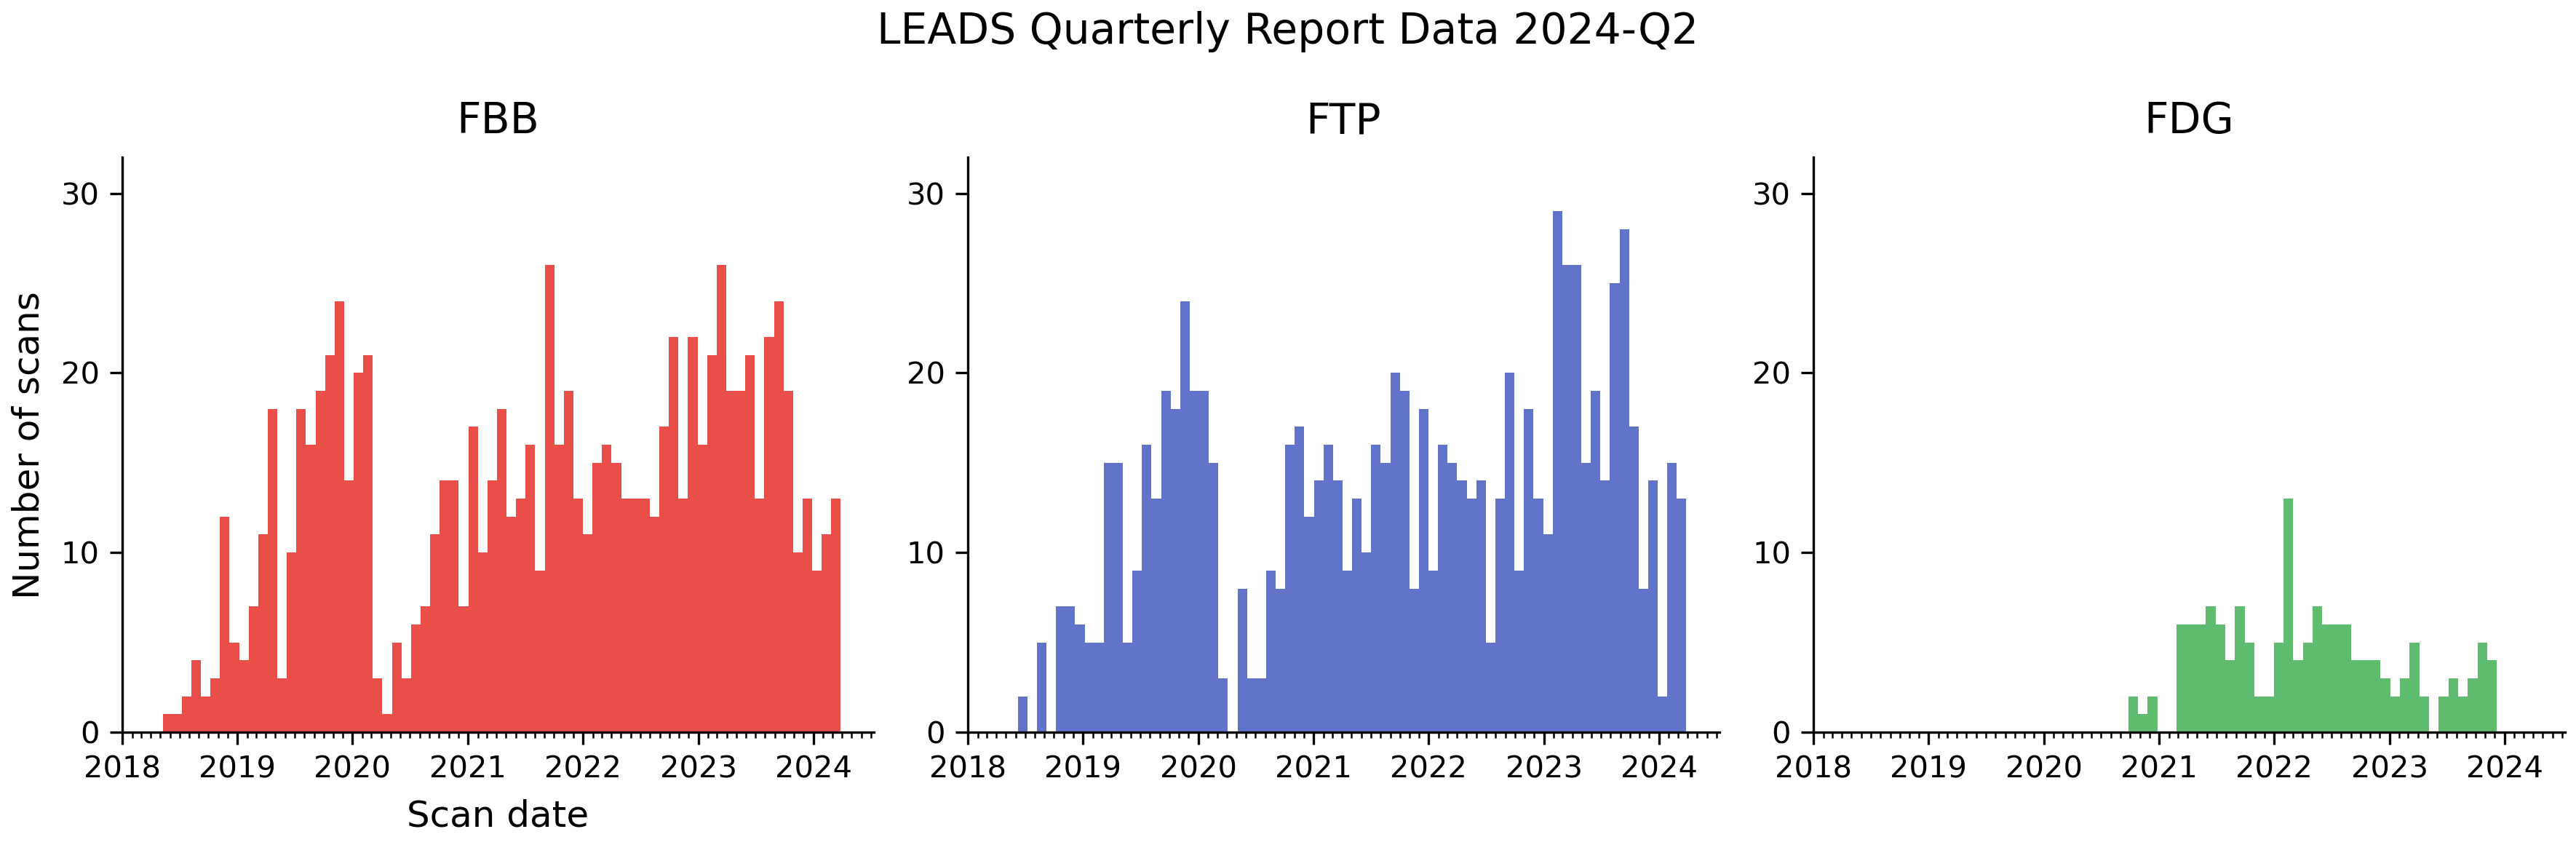

In [98]:
# Plot how many scans have been acquired over time, for each tracer
def get_nbins(dates):
    """Return the number of months between first and last dates."""
    dates = pd.to_datetime(dates)
    return int(np.rint((dates.max() - dates.min()).days / 30.4375))


# Define plot params
qreport_period = "2024-Q2"
date_rng = [pd.Timestamp("2018-01-01"), pd.Timestamp.now()]
yticks = [0, 10, 20, 30]
ylim = [0, 32]
lw = 0

# Initialize the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = np.ravel(ax)

# Plot each axis
iax = 0
_ax = ax[iax]
sns.histplot(
    pd.to_datetime(fbb6["FBBPET_Date"]),
    bins=get_nbins(fbb6["FBBPET_Date"]),
    color=co["r"],
    lw=lw,
    ax=_ax,
)
_ax.set_title("FBB")

iax += 1
_ax = ax[iax]
sns.histplot(
    pd.to_datetime(ftp6["FTPPET_Date"]),
    bins=get_nbins(ftp6["FTPPET_Date"]),
    color=co["b"],
    lw=lw,
    ax=_ax,
)
_ax.set_title("FTP")

iax += 1
_ax = ax[iax]
sns.histplot(
    pd.to_datetime(fdg6["FDGPET_Date"]),
    bins=get_nbins(fdg6["FDGPET_Date"]),
    color=co["g"],
    lw=lw,
    ax=_ax,
)
_ax.set_title("FDG")

# Set plot params
for iax, _ax in enumerate(ax):
    _ax.xaxis.set_minor_locator(mdates.MonthLocator())
    _ax.xaxis.set_major_locator(mdates.YearLocator())
    _ax.set_xlim(date_rng)
    _ax.set_ylim(ylim)
    _ax.set_yticks(yticks)
    if iax == 0:
        _ax.set_xlabel("Scan date")
        _ax.set_ylabel("Number of scans")
    else:
        _ax.set_xlabel("")
        _ax.set_ylabel("")

fig.suptitle(f"LEADS Quarterly Report Data {qreport_period}")
fig.tight_layout()

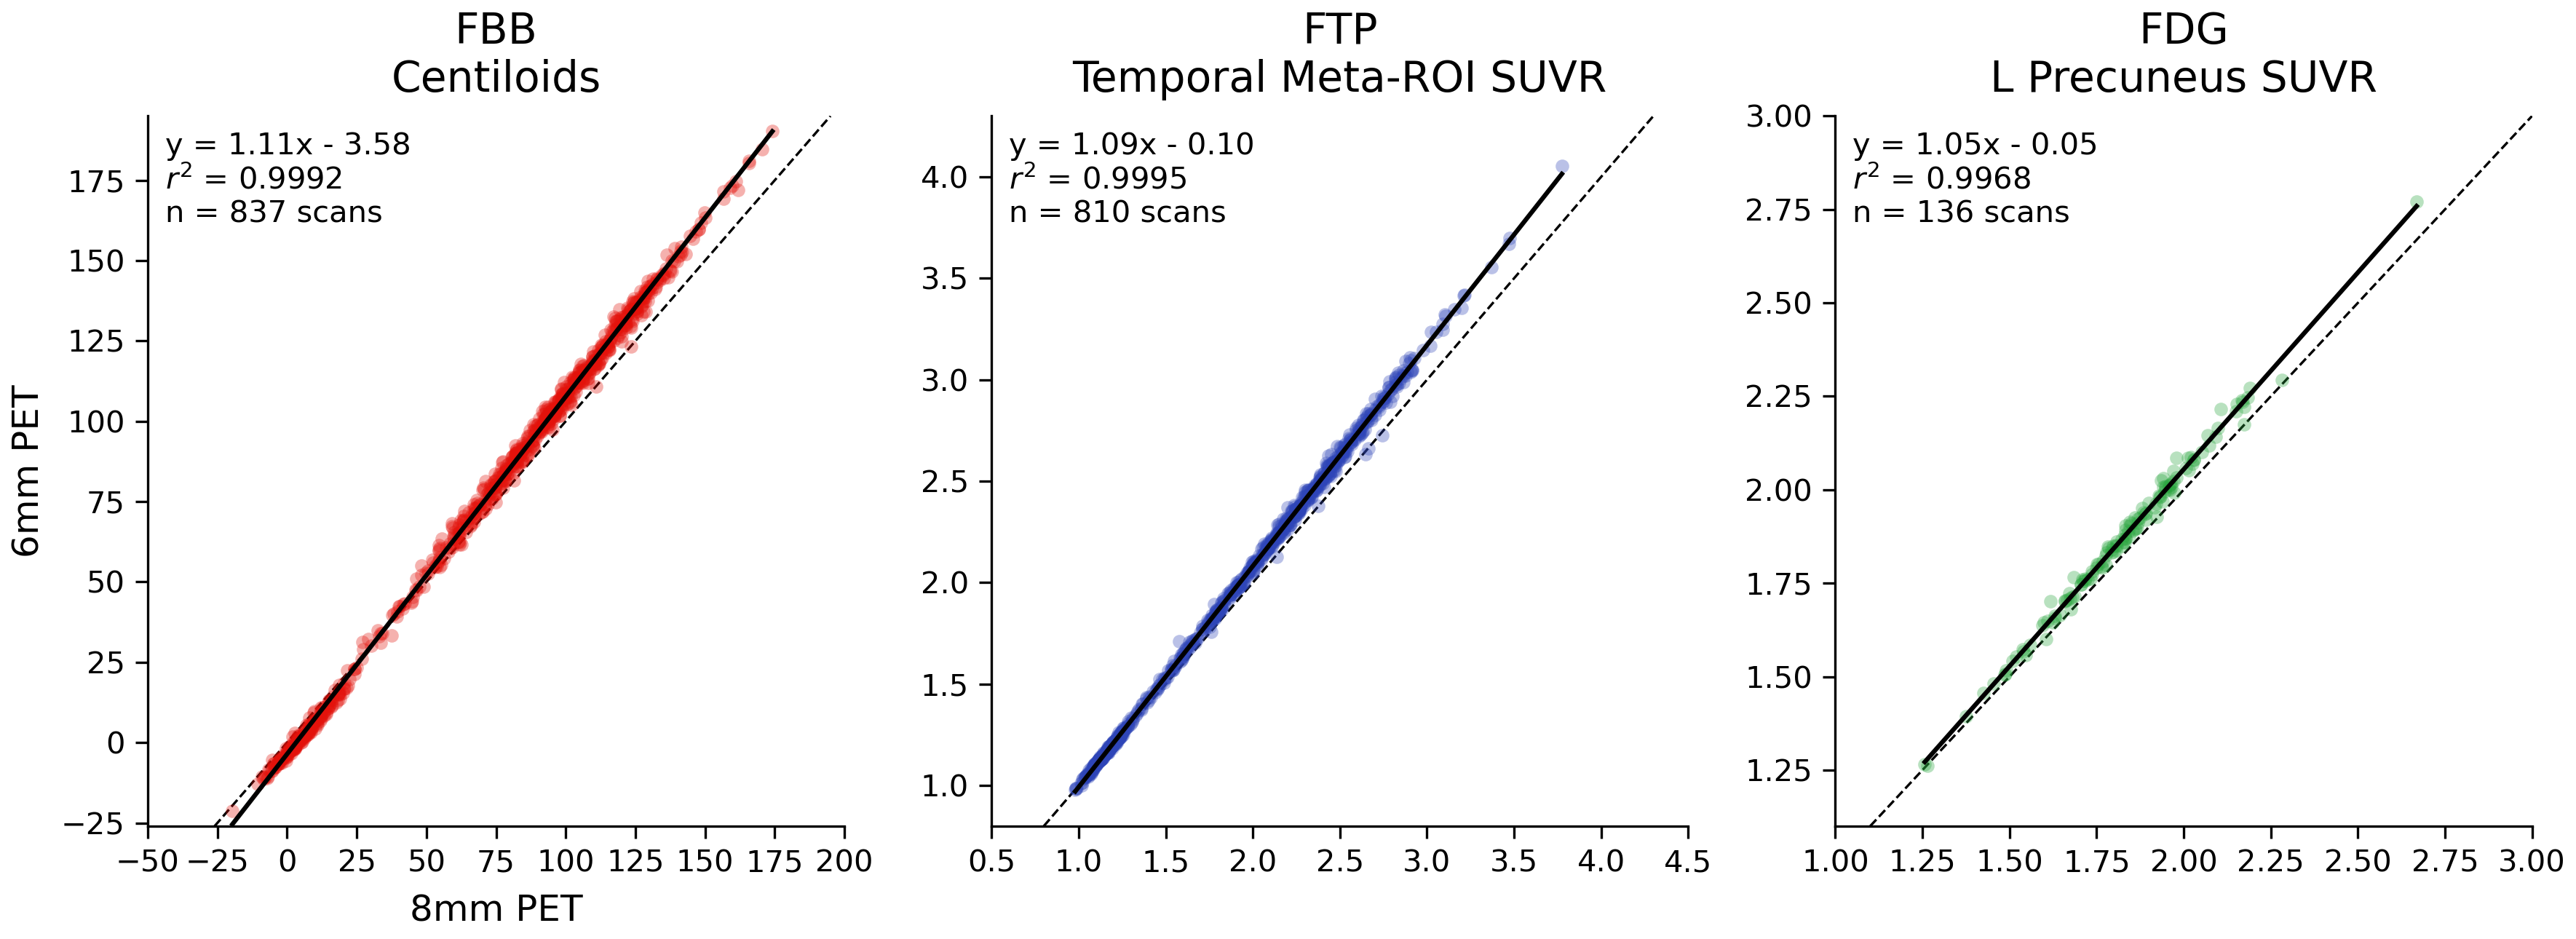

In [180]:
# Define plot params
qreport_period = "2024-Q2"
date_rng = [pd.Timestamp("2018-01-01"), pd.Timestamp.now()]
yticks = [0, 10, 20, 30]
ylim = [0, 32]
scatter_size = 20
alpha = 0.33
mew = 0

# Initialize the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5))
ax = np.ravel(ax)

# Plot each axis
iax = 0
_ax = ax[iax]
col = "MRIBASED_Composite_Centiloids"
sns.scatterplot(
    data=fbb,
    x=col + "_8",
    y=col + "_6",
    color=co["r"],
    alpha=alpha,
    s=scatter_size,
    linewidth=mew,
    edgecolors="k",
    ax=_ax,
)
lim = [
    np.round(fbb[[col + "_6", col + "_8"]].min().min(), 0) - 5,
    np.round(fbb[[col + "_6", col + "_8"]].max().max(), 0) + 5,
]
_ax.set_xlim(lim)
_ax.set_ylim(lim)
_ax.set_title("FBB\nCentiloids")

iax += 1
_ax = ax[iax]
col = "MetaROI_MRIBASED_SUVR"
sns.scatterplot(
    data=ftp,
    x=col + "_8",
    y=col + "_6",
    color=co["b"],
    alpha=alpha,
    s=scatter_size,
    linewidth=mew,
    edgecolors="k",
    ax=_ax,
)
lim = [
    np.round(ftp[[col + "_6", col + "_8"]].min().min(), 1) - 0.2,
    np.round(ftp[[col + "_6", col + "_8"]].max().max(), 1) + 0.2,
]
_ax.set_xlim(lim)
_ax.set_ylim(lim)
_ax.set_title("FTP\nTemporal Meta-ROI SUVR")

iax += 1
_ax = ax[iax]
col = "ctx_lh_precuneus_MRIBASED_SUVR"
sns.scatterplot(
    data=fdg,
    x=col + "_8",
    y=col + "_6",
    color=co["g"],
    alpha=alpha,
    s=scatter_size,
    linewidth=mew,
    edgecolors="k",
    ax=_ax,
)
lim = [
    np.round(fdg[[col + "_6", col + "_8"]].min().min(), 1) - 0.2,
    np.round(fdg[[col + "_6", col + "_8"]].max().max(), 1) + 0.2,
]
_ax.set_xlim(lim)
_ax.set_ylim(lim)
_ax.set_title("FDG\nL Precuneus SUVR")

# Set plot params
for iax, _ax in enumerate(ax):
    # Add a line of best fit
    x = _ax.collections[0].get_offsets()[:, 0]
    y = _ax.collections[0].get_offsets()[:, 1]
    slope, icpt = np.polyfit(x, y, 1)
    rval, _ = stats.pearsonr(x, y)
    xvals = np.linspace(x.data.min(), x.data.max(), 100)
    yvals = (xvals * slope) + icpt
    _ax.plot(xvals, yvals, "k-", lw=1.5)
    annot = (
        f"y = {slope:.2f}x"
        + (" + " if icpt >= 0 else " - ")
        + f"{abs(icpt):.2f}\n$r^2$ = {rval:.4f}\nn = {len(x)} scans"
    )
    _ax.annotate(annot, (0.025, 0.85), xycoords="axes fraction")

    # Add a y=x line
    lims = [
        np.min([_ax.get_xlim(), _ax.get_ylim()]),
        np.max([_ax.get_xlim(), _ax.get_ylim()]),
    ]
    _ax.plot(lims, lims, "k--", lw=0.8, zorder=0)

    # Format ticks
    _ax.set_xticks(_ax.get_yticks())

    # Format labels
    if iax == 0:
        _ax.set_xlabel("8mm PET")
        _ax.set_ylabel("6mm PET")
    else:
        _ax.set_xlabel("")
        _ax.set_ylabel("")

# Make each axis the same size on the figure
fig.tight_layout(rect=[0, 0, 1, 1])
fig.show()

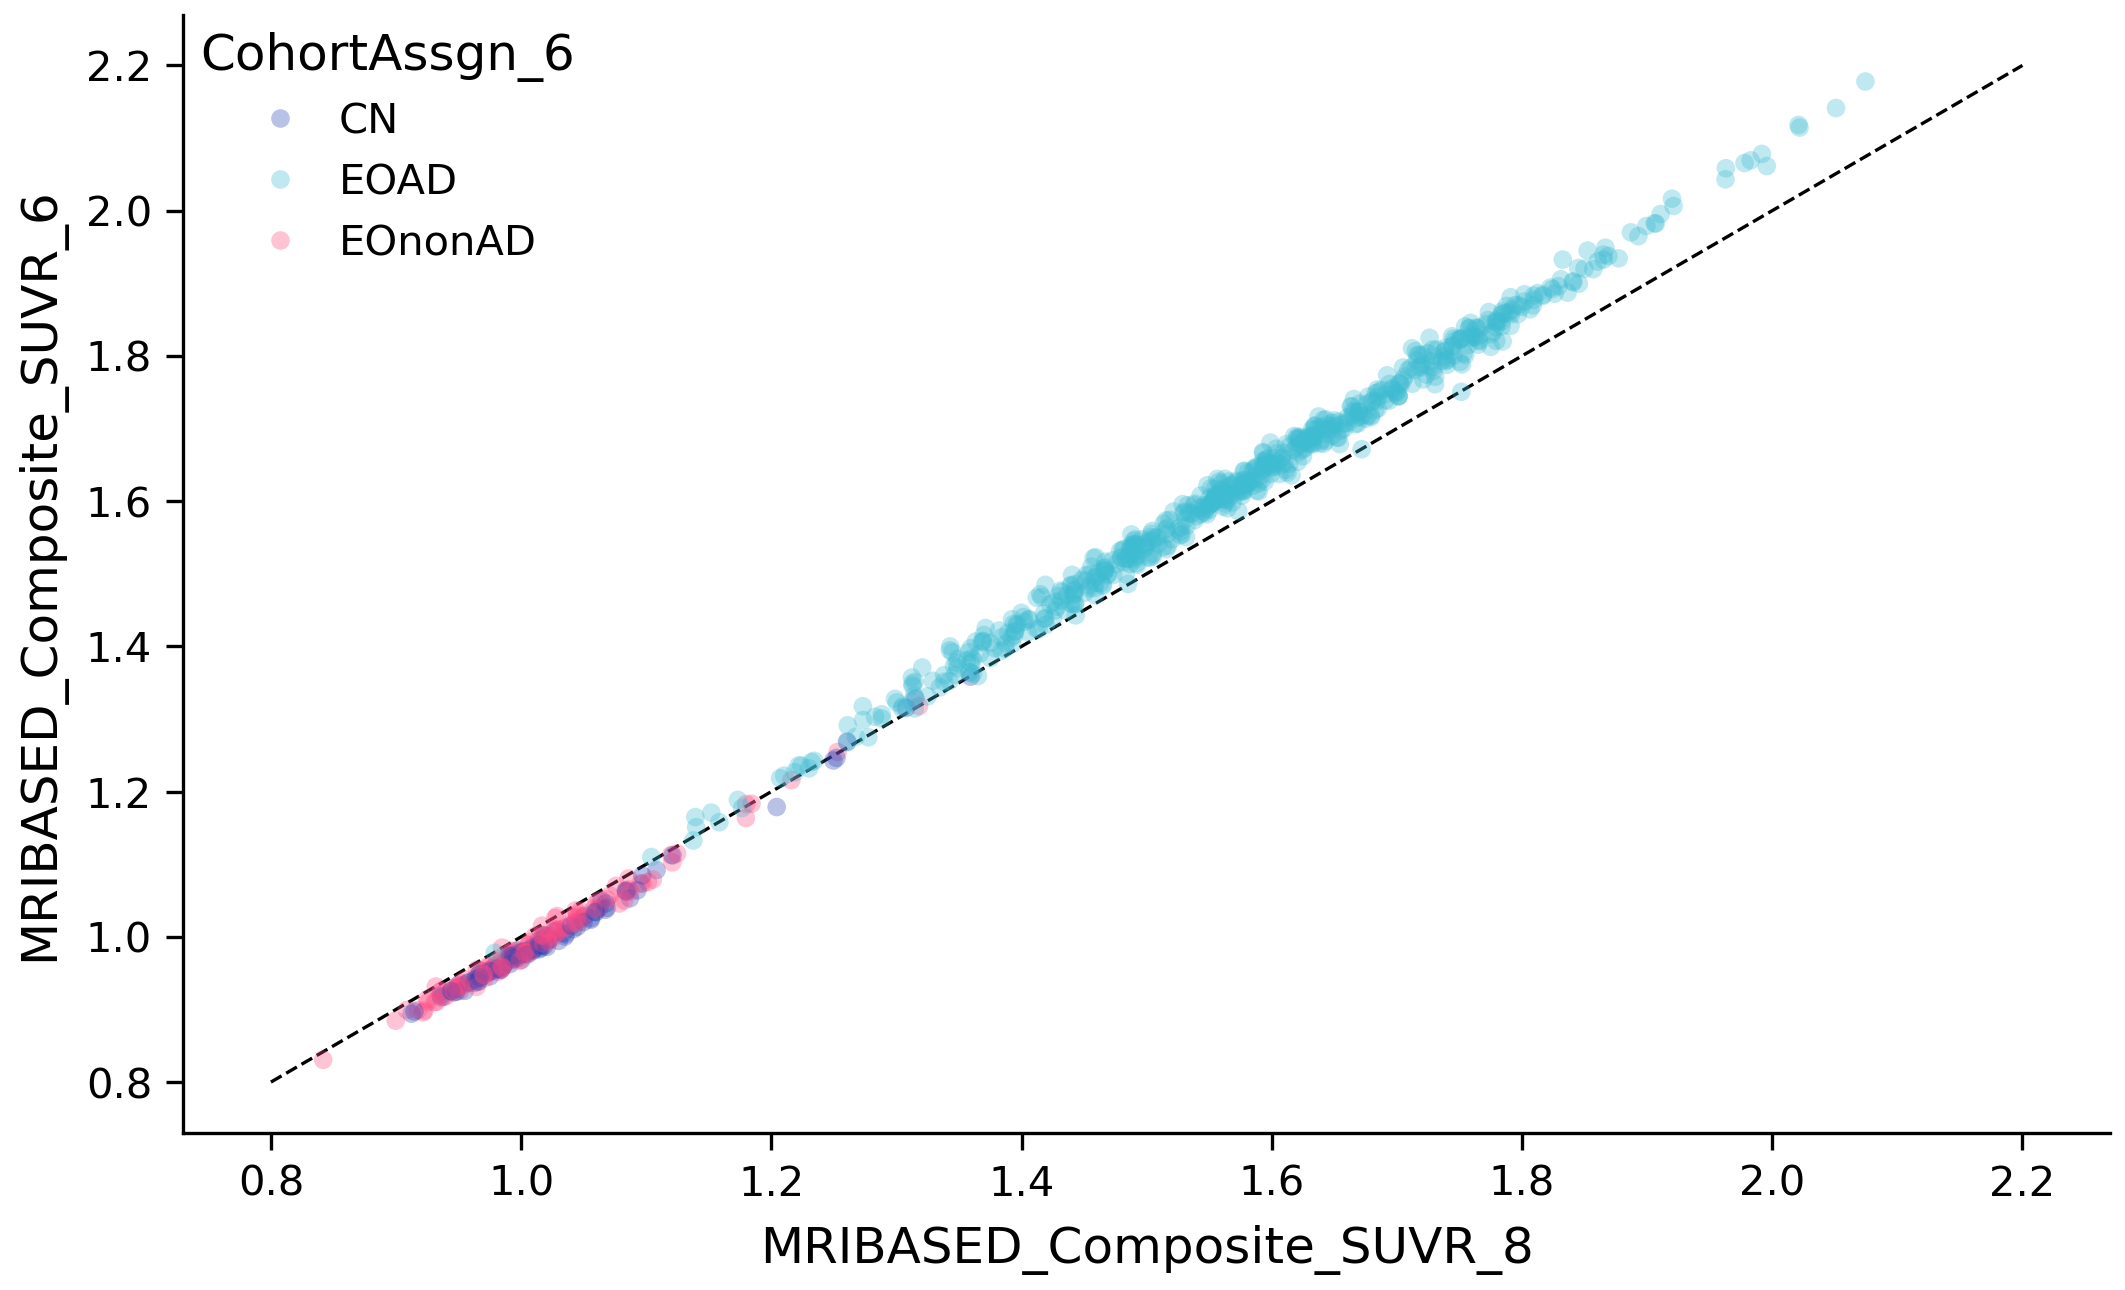

In [181]:
col = "MRIBASED_Composite_SUVR"
sns.scatterplot(
    data=fbb, x=col + "_8", y=col + "_6", lw=0, s=20, alpha=0.33, hue="CohortAssgn_6"
)
plt.plot([0.8, 2.2], [0.8, 2.2], "k--", lw=0.8, zorder=0)